In [1]:
import os,sys, json, random
from tqdm import tqdm
import math
import numpy as np

sys.path.append('..')
sys.path.append('../../generative-models-main/')

import torch
from torch.utils.data import TensorDataset, DataLoader

from tensorboardX import SummaryWriter
# Set the torch seed for result reproducibility
torch_seed = 0
torch.manual_seed(torch_seed)

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

import utils
import plot

from models import *

from numpyencoder import NumpyEncoder
from sklearn.preprocessing import MinMaxScaler, StandardScaler

In [2]:
#Load the date from 2021
train_series, train_attr, val_series, val_attr, test_series, test_attr = utils.get_data('2021')

#Standardize the data
train_series, val_series, test_series, scaler_data = utils.standardize_data(train_series, val_series, test_series)

#perform one-hot encoding
ONEHOTENCODE = ['is_weekend','season','PV']
train_attr = utils.one_hot_encode_columns(train_attr, ONEHOTENCODE)
val_attr = utils.one_hot_encode_columns(val_attr, ONEHOTENCODE)
test_attr = utils.one_hot_encode_columns(test_attr, ONEHOTENCODE)

# MinMax scale the attributes -> this keeps the scales, which might be important for some attributes!
train_attr, val_attr, test_attr, scaler_attr = utils.minmax_scale_attributes(train_attr,val_attr,test_attr)

#Create dataloaders for pytorch
train_dataset = TensorDataset(torch.tensor(train_series, dtype=torch.float32), torch.tensor(train_attr, dtype=torch.float32))
val_dataset = TensorDataset(torch.tensor(val_series, dtype=torch.float32), torch.tensor(val_attr, dtype=torch.float32))
test_dataset = TensorDataset(torch.tensor(test_series, dtype=torch.float32), torch.tensor(test_attr, dtype=torch.float32))

test_attr  = torch.tensor(test_attr, dtype=torch.float32)

In [3]:
training_run_name = 'run5'

output_main_path = r'C:\Thesis\scripts\normalizing-flows\runs'
output_path = os.path.join(output_main_path,training_run_name)
os.makedirs(output_path, exist_ok=True)

nb_layers = 2
nb_neurons = 200
out_size = 16
learning_rate = 1e-3
weight_decay = 1e-4

nb_epochs = 100
batch_size = 64

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

config = {
    'name': 'UMNN_M',
    'nb_steps': 2,
    'nb_layers': nb_layers,
    'nb_neurons': nb_neurons,
    'out_size': out_size,
    'weight_decay': weight_decay,
    'learning_rate': learning_rate,
    'conditioner_type': 'AutoregressiveConditioner',
    'normalizer_type': 'MonotonicNormalizer',
    'conditioner_args': {
        'in_size': train_series.shape[1] ,
        'hidden': [nb_neurons]*nb_layers,
        'out_size': out_size,
        'cond_in':train_attr.shape[1]},
    'normalizer_args': {
        'integrand_net': [out_size * 2, out_size * 2, out_size * 2],
        'cond_size':out_size,
        'nb_steps':50,
        'solver':'CCParallel',
        'hot_encoding': True},
    'Adam_args':{
        'lr': learning_rate,
        'weight_decay':weight_decay}
    }


with open(os.path.join(output_path, config['name']+'.json'), 'w') as file:
    json.dump(config, file, cls=NumpyEncoder)

flow = buildFCNormalizingFlow(nb_steps=config['nb_steps'], 
                             conditioner_type=AutoregressiveConditioner,
                             conditioner_args=config['conditioner_args'], 
                             normalizer_type=MonotonicNormalizer,
                             normalizer_args=config['normalizer_args'])

opt = torch.optim.Adam(flow.parameters(), lr=config['learning_rate'], weight_decay=config['weight_decay'])

In [4]:
flow.to(device)
loss_list = []
best_flow = flow

torch.cuda.empty_cache()

# Initialize SummaryWriter to log metrics
writer = SummaryWriter(output_path)

for epoch in range(nb_epochs):
    loss_tot = 0
    
    loss_batch = 0
    for y_batch, x_batch in tqdm(train_loader):
        if np.isnan(y_batch).any():
            continue
        
        # We compute the log-likelihood as well as the base variable
        ll, _ = flow.compute_ll(x=y_batch.to(device), context=x_batch.to(device))
        
        # Here we would like to maximize the log-likelihood of our model!
        loss = -ll.mean()
        opt.zero_grad()
        loss.backward()
        opt.step()
        loss_batch += loss.item()

    # LS loss is the average over all the batch
    loss_ls = loss_batch / len(train_loader)

    loss_batch = 0
    for y_batch, x_batch in val_loader:
        ll, _ = flow.compute_ll(x=y_batch.to(device), context=x_batch.to(device))
        loss_batch += -ll.mean().item()
    loss_vs = loss_batch / len(val_loader)

    loss_batch = 0
    for y_batch, x_batch in test_loader:
        ll, _ = flow.compute_ll(x=y_batch.to(device), context=x_batch.to(device))
        loss_batch += -ll.mean().item()
    loss_test = loss_batch / len(test_loader)

    loss_list.append([loss_ls, loss_vs, loss_test])

    ll_VS_min = np.nanmin(np.asarray(loss_list)[:, 1]) # ignore nan value when considering the min

    if not math.isnan(loss_vs) and loss_vs <= ll_VS_min:
        # print('NEW MIN ON VS at epoch %s loss_vs %.2f ll_VS_min %.2f' %(epoch, loss_vs, ll_VS_min))
        best_flow = flow # update the best flow
        output_model_path = os.path.join(output_path,'best_model.pt')
        torch.save(best_flow, output_model_path)

    if epoch % 1 == 0 and epoch != 0:
        # print("Epoch {:.0f} Approximate time left : {:2f} min - LS loss: {:4f} VS loss: {:4f} TEST loss: {:4f}".format(epoch, time_tot / (epoch + 1) * (nb_epoch - (epoch + 1)) / 60, loss_ls, loss_vs, loss_test))
        output_model_path = os.path.join(output_path,f'model{epoch}.pt')
        torch.save(flow, output_model_path)
        print("Epoch {:.0f} - LS loss: {:4f} VS loss: {:4f} TEST loss: {:4f}".format(epoch, loss_ls, loss_vs, loss_test), end="\r", flush=True)

    writer.add_scalar('Losses/train', loss_ls, epoch)
    writer.add_scalar('Losses/val', loss_vs, epoch)
    writer.add_scalar('Losses/test', loss_test, epoch)

100%|██████████| 355/355 [00:06<00:00, 51.93it/s]


100%|██████████| 355/355 [00:06<00:00, 52.09it/s]


100%|██████████| 355/355 [00:06<00:00, 51.97it/s]


100%|██████████| 355/355 [00:06<00:00, 51.71it/s]


100%|██████████| 355/355 [00:06<00:00, 51.82it/s]


100%|██████████| 355/355 [00:06<00:00, 51.92it/s]


100%|██████████| 355/355 [00:06<00:00, 52.14it/s]


100%|██████████| 355/355 [00:06<00:00, 52.14it/s]


100%|██████████| 355/355 [00:06<00:00, 51.84it/s]


100%|██████████| 355/355 [00:06<00:00, 51.66it/s]


100%|██████████| 355/355 [00:06<00:00, 52.01it/s]


100%|██████████| 355/355 [00:06<00:00, 52.20it/s]


100%|██████████| 355/355 [00:06<00:00, 52.10it/s]


100%|██████████| 355/355 [00:07<00:00, 50.19it/s]


100%|██████████| 355/355 [00:07<00:00, 49.75it/s]


100%|██████████| 355/355 [00:07<00:00, 50.17it/s]


100%|██████████| 355/355 [00:07<00:00, 50.20it/s]


100%|██████████| 355/355 [00:07<00:00, 50.15it/s]


100%|██████████| 355/355 [00:07<00:00, 50.26it/s]


100%|██████████| 355/355 [00:07<00:00, 50.45it/s]


100%|██████████| 355/355 [00:07<00:00, 49.92it/s]


100%|██████████| 355/355 [00:07<00:00, 50.01it/s]


100%|██████████| 355/355 [00:07<00:00, 49.56it/s]


100%|██████████| 355/355 [00:07<00:00, 47.65it/s]


100%|██████████| 355/355 [00:07<00:00, 49.29it/s]


100%|██████████| 355/355 [00:07<00:00, 50.03it/s]


100%|██████████| 355/355 [00:08<00:00, 41.51it/s]


100%|██████████| 355/355 [00:08<00:00, 40.64it/s]


100%|██████████| 355/355 [00:08<00:00, 40.95it/s]


100%|██████████| 355/355 [00:09<00:00, 39.17it/s]


100%|██████████| 355/355 [00:06<00:00, 50.76it/s]


100%|██████████| 355/355 [00:06<00:00, 50.93it/s]


100%|██████████| 355/355 [00:07<00:00, 50.67it/s]


100%|██████████| 355/355 [00:07<00:00, 49.99it/s]


100%|██████████| 355/355 [00:07<00:00, 50.38it/s]


100%|██████████| 355/355 [00:07<00:00, 50.28it/s]


100%|██████████| 355/355 [00:07<00:00, 50.09it/s]


100%|██████████| 355/355 [00:07<00:00, 50.17it/s]


100%|██████████| 355/355 [00:07<00:00, 50.02it/s]


100%|██████████| 355/355 [00:07<00:00, 48.99it/s]


100%|██████████| 355/355 [00:07<00:00, 48.67it/s]


100%|██████████| 355/355 [00:07<00:00, 49.30it/s]


100%|██████████| 355/355 [00:08<00:00, 43.71it/s]


100%|██████████| 355/355 [00:08<00:00, 41.87it/s]


100%|██████████| 355/355 [00:08<00:00, 40.68it/s]


100%|██████████| 355/355 [00:08<00:00, 39.60it/s]


100%|██████████| 355/355 [00:08<00:00, 40.13it/s]


100%|██████████| 355/355 [00:09<00:00, 39.23it/s]


100%|██████████| 355/355 [00:08<00:00, 40.05it/s]


100%|██████████| 355/355 [00:08<00:00, 41.86it/s]


100%|██████████| 355/355 [00:08<00:00, 40.66it/s]


100%|██████████| 355/355 [00:08<00:00, 41.46it/s]


100%|██████████| 355/355 [00:08<00:00, 41.51it/s]


100%|██████████| 355/355 [00:09<00:00, 38.51it/s]


100%|██████████| 355/355 [00:08<00:00, 40.22it/s]


100%|██████████| 355/355 [00:08<00:00, 42.44it/s]


100%|██████████| 355/355 [00:08<00:00, 41.80it/s]


100%|██████████| 355/355 [00:08<00:00, 41.75it/s]


100%|██████████| 355/355 [00:08<00:00, 41.74it/s]


100%|██████████| 355/355 [00:08<00:00, 41.27it/s]


100%|██████████| 355/355 [00:08<00:00, 42.46it/s]


100%|██████████| 355/355 [00:08<00:00, 41.19it/s]


100%|██████████| 355/355 [00:08<00:00, 40.21it/s]


100%|██████████| 355/355 [00:08<00:00, 41.92it/s]


100%|██████████| 355/355 [00:08<00:00, 42.40it/s]


100%|██████████| 355/355 [00:08<00:00, 42.47it/s]


100%|██████████| 355/355 [00:08<00:00, 40.37it/s]


100%|██████████| 355/355 [00:07<00:00, 49.98it/s]


  9%|▉         | 33/355 [00:00<00:06, 49.62it/s]


KeyboardInterrupt: 

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


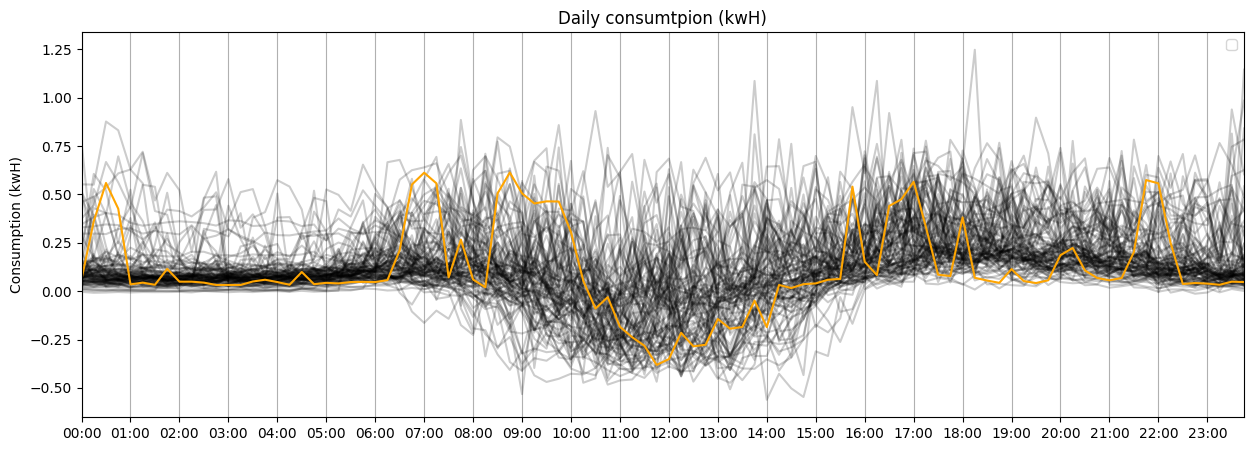

In [13]:
best_flow = torch.load(r'C:\Thesis\scripts\normalizing-flows\runs\run5\best_model.pt').to('cuda')
index = 4
n = 50
nb_output, cond_in = config['conditioner_args']['in_size'], config['conditioner_args']['cond_in']
predictions = best_flow.invert(z=torch.randn(n, nb_output).to(device), context=torch.tensor(np.tile(test_attr[index], n).reshape(n, cond_in)).to(device).float()).cpu().detach().numpy()

import plot
transform = scaler_data.inverse_transform(predictions)
org = scaler_data.inverse_transform([test_series[index]])
plot.plotday(np.concatenate([transform,org]))

In [47]:
from sklearn.metrics import mean_squared_error, mean_absolute_error

def calculate_metrics_model(model, test_series, test_attr, scaler_data):
    energy_score = []
    mse = []
    mae = []
    test_series = scaler_data.inverse_transform(test_series)
    for i,(org_serie,attr) in tqdm(enumerate(zip(test_series,test_attr)),total=len(test_attr)):
        n = 50
        new_samples = model.invert(z=torch.randn(n, nb_output).to(device), context=torch.tensor(np.tile(attr, n).reshape(n, cond_in)).to(device)).cpu().detach().numpy()
        new_samples = scaler_data.inverse_transform(new_samples)
        energy_score.append(utils.calculate_energy_score([1/n]*n, new_samples, org_serie))
        mse.append(mean_squared_error(new_samples,np.array([org_serie]*n)))
        mae.append(mean_absolute_error(new_samples,np.array([org_serie]*n)))

        print('Energy Score:', np.mean(energy_score))
        print('mse', np.mean(mse))
        print('mae', np.mean(mae))

In [48]:
calculate_metrics_model(best_flow, test_series, test_attr,scaler_data)

  0%|          | 1/4857 [00:02<4:02:32,  3.00s/it]

Energy Score: 1.9051136339641086
mse 0.15260655042658447
mae 0.2510470483067495


  0%|          | 2/4857 [00:06<4:03:47,  3.01s/it]

Energy Score: 1.7310700421539866
mse 0.12659351187592371
mae 0.23187496860142526


  0%|          | 3/4857 [00:08<3:52:29,  2.87s/it]

Energy Score: 1.6874957383489322
mse 0.11772062202026488
mae 0.22023946677642692


  0%|          | 4/4857 [00:11<3:52:56,  2.88s/it]

Energy Score: 1.6743167004222665
mse 0.11292504927527804
mae 0.21410078895693346


  0%|          | 5/4857 [00:14<3:41:45,  2.74s/it]

Energy Score: 1.6220628747028818
mse 0.1037517226744622
mae 0.20773171911112892


  0%|          | 6/4857 [00:16<3:43:29,  2.76s/it]

Energy Score: 1.6132934280840894
mse 0.10423253305007492
mae 0.20801757278556246


  0%|          | 7/4857 [00:19<3:42:35,  2.75s/it]

Energy Score: 1.5872103636563584
mse 0.10020238889974746
mae 0.20602481792240926


  0%|          | 8/4857 [00:22<3:44:46,  2.78s/it]

Energy Score: 1.5691673341731642
mse 0.097430891602895
mae 0.20350043648795144


  0%|          | 9/4857 [00:25<3:39:17,  2.71s/it]

Energy Score: 1.5827049312269506
mse 0.0964374968108756
mae 0.20466716485112732


  0%|          | 10/4857 [00:28<3:46:28,  2.80s/it]

Energy Score: 1.587226844926415
mse 0.09793016253041686
mae 0.20612915221094114


  0%|          | 11/4857 [00:30<3:48:26,  2.83s/it]

Energy Score: 1.5493492048402073
mse 0.0942298505053253
mae 0.2009142464273469


  0%|          | 12/4857 [00:33<3:50:02,  2.85s/it]

Energy Score: 1.586867581506935
mse 0.09838436489844947
mae 0.20653550721434133


  0%|          | 13/4857 [00:36<3:50:44,  2.86s/it]

Energy Score: 1.568409598492547
mse 0.09645871826756228
mae 0.20413211295646694


  0%|          | 14/4857 [00:39<4:00:44,  2.98s/it]

Energy Score: 1.550428736454339
mse 0.09471390922770985
mae 0.20179835301307314


  0%|          | 15/4857 [00:42<4:00:58,  2.99s/it]

Energy Score: 1.5710648482571576
mse 0.09769500673203574
mae 0.20549537864844028


  0%|          | 16/4857 [00:45<3:55:28,  2.92s/it]

Energy Score: 1.558140458624185
mse 0.09600451199754079
mae 0.20427402740150036


  0%|          | 17/4857 [00:48<3:55:46,  2.92s/it]

Energy Score: 1.572548836994988
mse 0.09799497779343218
mae 0.20690137417794685


  0%|          | 18/4857 [00:51<3:50:43,  2.86s/it]

Energy Score: 1.5559410270219485
mse 0.09553278763669543
mae 0.20412896093839497


  0%|          | 19/4857 [00:54<3:46:04,  2.80s/it]

Energy Score: 1.549814904420638
mse 0.09394658187031431
mae 0.20249802053152988


  0%|          | 20/4857 [00:57<3:49:05,  2.84s/it]

Energy Score: 1.5270580784512977
mse 0.09190583337895514
mae 0.20032766349786146


  0%|          | 21/4857 [01:00<3:54:23,  2.91s/it]

Energy Score: 1.5143665754710387
mse 0.09062387317997407
mae 0.19843864145420742


  0%|          | 22/4857 [01:02<3:54:39,  2.91s/it]

Energy Score: 1.4940908799925294
mse 0.0888092814680951
mae 0.19614671858161117


  0%|          | 23/4857 [01:06<3:58:38,  2.96s/it]

Energy Score: 1.481144730803338
mse 0.08730619215139433
mae 0.19448137120245254


  0%|          | 24/4857 [01:08<3:48:50,  2.84s/it]

Energy Score: 1.4760433093639147
mse 0.08680267833520357
mae 0.19432577928893935


  1%|          | 25/4857 [01:11<3:48:08,  2.83s/it]

Energy Score: 1.4878538805654775
mse 0.08772733187176783
mae 0.19537149590231828


  1%|          | 26/4857 [01:13<3:40:30,  2.74s/it]

Energy Score: 1.4915675523136758
mse 0.08745698200001019
mae 0.19584550902364756


  1%|          | 27/4857 [01:16<3:41:41,  2.75s/it]

Energy Score: 1.4817851943180695
mse 0.0863726781500498
mae 0.19487155597059946


  1%|          | 28/4857 [01:19<3:41:10,  2.75s/it]

Energy Score: 1.4651039500337308
mse 0.0844274798400582
mae 0.1918869762304365


  1%|          | 29/4857 [01:22<3:49:45,  2.86s/it]

Energy Score: 1.4607190162356567
mse 0.08370926143161037
mae 0.19113320432519498


  1%|          | 30/4857 [01:25<3:45:10,  2.80s/it]

Energy Score: 1.4524132397455787
mse 0.08280970756945565
mae 0.19019528843822114


  1%|          | 31/4857 [01:28<3:45:51,  2.81s/it]

Energy Score: 1.4552303761813603
mse 0.08281536681082685
mae 0.1908230741560539


  1%|          | 32/4857 [01:30<3:42:43,  2.77s/it]

Energy Score: 1.4451622966335458
mse 0.08182203749568201
mae 0.18977498236998835


  1%|          | 33/4857 [01:33<3:42:59,  2.77s/it]

Energy Score: 1.439594192073557
mse 0.08110887727067143
mae 0.1891982389979071


  1%|          | 34/4857 [01:36<3:48:10,  2.84s/it]

Energy Score: 1.4306819608530887
mse 0.0802929504043986
mae 0.18849966644768584


  1%|          | 35/4857 [01:39<3:48:18,  2.84s/it]

Energy Score: 1.422563194881766
mse 0.07914163383395843
mae 0.18709743480995675


  1%|          | 36/4857 [01:42<3:43:23,  2.78s/it]

Energy Score: 1.4278434840227834
mse 0.07921495251151096
mae 0.18744519186414882


  1%|          | 37/4857 [01:44<3:45:10,  2.80s/it]

Energy Score: 1.4218602903817
mse 0.07854680314949002
mae 0.18689997778424078


  1%|          | 38/4857 [01:47<3:43:16,  2.78s/it]

Energy Score: 1.4171570878001354
mse 0.07778728018591445
mae 0.18640242983012226


  1%|          | 39/4857 [01:50<3:40:12,  2.74s/it]

Energy Score: 1.413251914269224
mse 0.07694872110138705
mae 0.18567846449597963


  1%|          | 40/4857 [01:53<3:45:14,  2.81s/it]

Energy Score: 1.4054720376410255
mse 0.07584892158032386
mae 0.18432904363782215


  1%|          | 41/4857 [01:55<3:39:46,  2.74s/it]

Energy Score: 1.404512427944252
mse 0.07509881975742695
mae 0.1838508191707797


  1%|          | 42/4857 [01:58<3:38:14,  2.72s/it]

Energy Score: 1.3959666145530867
mse 0.07410343949953234
mae 0.18238800426722468


  1%|          | 43/4857 [02:01<3:42:08,  2.77s/it]

Energy Score: 1.3936345234766123
mse 0.07340900825657823
mae 0.18162275791653404


  1%|          | 44/4857 [02:04<3:39:43,  2.74s/it]

Energy Score: 1.3945857900830299
mse 0.07314684345425694
mae 0.18142854295555372


  1%|          | 45/4857 [02:06<3:39:36,  2.74s/it]

Energy Score: 1.3896032892772063
mse 0.07247787510216724
mae 0.1807202317092156


  1%|          | 46/4857 [02:09<3:46:12,  2.82s/it]

Energy Score: 1.3902406386651323
mse 0.07238401185874473
mae 0.18018466050912657


  1%|          | 47/4857 [02:11<3:31:31,  2.64s/it]

Energy Score: 1.3621197120291086
mse 0.07084969378108759
mae 0.17660605245024721


  1%|          | 48/4857 [02:14<3:23:15,  2.54s/it]

Energy Score: 1.3371619677260291
mse 0.0694110866781177
mae 0.17354746492478104


  1%|          | 49/4857 [02:16<3:18:32,  2.48s/it]

Energy Score: 1.3148209255846854
mse 0.06806342037624688
mae 0.17074367964157303


  1%|          | 50/4857 [02:18<3:12:03,  2.40s/it]

Energy Score: 1.2944126548549328
mse 0.06679023104200149
mae 0.1681739850000324


  1%|          | 51/4857 [02:21<3:11:11,  2.39s/it]

Energy Score: 1.2790578813612166
mse 0.06572690882898735
mae 0.16616170648137654


  1%|          | 52/4857 [02:23<3:07:40,  2.34s/it]

Energy Score: 1.2571212097376925
mse 0.06447938854979104
mae 0.16338791201885494


  1%|          | 53/4857 [02:25<3:05:34,  2.32s/it]

Energy Score: 1.2378038913398979
mse 0.0633263791749337
mae 0.1610087668920392


  1%|          | 54/4857 [02:27<3:05:09,  2.31s/it]

Energy Score: 1.2245558550825166
mse 0.062418246009319486
mae 0.15921917343545852


  1%|          | 55/4857 [02:30<3:10:51,  2.38s/it]

Energy Score: 1.2168504651420986
mse 0.061753522070805304
mae 0.15796585731061508


  1%|          | 56/4857 [02:33<3:12:42,  2.41s/it]

Energy Score: 1.2062791159382247
mse 0.060974413458155005
mae 0.1565544488561376


  1%|          | 57/4857 [02:35<3:09:57,  2.37s/it]

Energy Score: 1.1891589516816676
mse 0.05995274904625853
mae 0.1544432908124317


  1%|          | 58/4857 [02:37<3:05:33,  2.32s/it]

Energy Score: 1.17039658428372
mse 0.05892767476377481
mae 0.1520734811625291


  1%|          | 59/4857 [02:39<3:08:26,  2.36s/it]

Energy Score: 1.1632697934475948
mse 0.05837103168659142
mae 0.15110501082955757


  1%|          | 60/4857 [02:42<3:09:59,  2.38s/it]

Energy Score: 1.1516706807539088
mse 0.057622996460230905
mae 0.14967566907020927


  1%|▏         | 61/4857 [02:44<3:07:03,  2.34s/it]

Energy Score: 1.1378756536965167
mse 0.05672909307117864
mae 0.14781717158875848


  1%|▏         | 62/4857 [02:46<2:58:19,  2.23s/it]

Energy Score: 1.1210485421186578
mse 0.05582028836274319
mae 0.1456768530905754


  1%|▏         | 63/4857 [02:48<2:57:15,  2.22s/it]

Energy Score: 1.1071860800996107
mse 0.05498870694903715
mae 0.14395704675774829


  1%|▏         | 64/4857 [02:50<2:52:03,  2.15s/it]

Energy Score: 1.092184913618853
mse 0.0541465881350309
mae 0.1420703241142443


  1%|▏         | 65/4857 [02:53<2:59:24,  2.25s/it]

Energy Score: 1.0791261697931254
mse 0.05334968228214128
mae 0.1403824221115202


  1%|▏         | 66/4857 [02:55<2:58:07,  2.23s/it]

Energy Score: 1.0735290777867843
mse 0.05283095669993319
mae 0.13934138070198593


  1%|▏         | 67/4857 [02:57<2:56:44,  2.21s/it]

Energy Score: 1.0670436326129689
mse 0.052271732167373075
mae 0.13817510160496593


  1%|▏         | 68/4857 [02:59<2:53:34,  2.17s/it]

Energy Score: 1.0526963108330365
mse 0.0515091409118893
mae 0.13636491161211697


  1%|▏         | 69/4857 [03:01<2:55:27,  2.20s/it]

Energy Score: 1.040131823543426
mse 0.050785335151909465
mae 0.13481936056947266


  1%|▏         | 70/4857 [03:04<2:54:11,  2.18s/it]

Energy Score: 1.0265911071827405
mse 0.05006547241466386
mae 0.1331142893575782


  1%|▏         | 71/4857 [03:06<2:56:15,  2.21s/it]

Energy Score: 1.0186468366575776
mse 0.049534435074814885
mae 0.13208763244331134


  1%|▏         | 72/4857 [03:08<2:59:24,  2.25s/it]

Energy Score: 1.0072818559724324
mse 0.04887659218596046
mae 0.13067653314293698


  2%|▏         | 73/4857 [03:11<3:02:26,  2.29s/it]

Energy Score: 0.9993555615032756
mse 0.048339266830284194
mae 0.12947358908816434


  2%|▏         | 74/4857 [03:13<3:02:17,  2.29s/it]

Energy Score: 0.9922601858277276
mse 0.04781959983479749
mae 0.1284249499053616


  2%|▏         | 75/4857 [03:15<3:04:57,  2.32s/it]

Energy Score: 0.9835923041145713
mse 0.047271872184772884
mae 0.12725189454298905


  2%|▏         | 76/4857 [03:18<3:05:22,  2.33s/it]

Energy Score: 0.9792978377582671
mse 0.04685027354192641
mae 0.12634989982004544


  2%|▏         | 77/4857 [03:20<3:05:22,  2.33s/it]

Energy Score: 0.9718106723489145
mse 0.04632997130814358
mae 0.12524127010995276


  2%|▏         | 78/4857 [03:22<2:58:09,  2.24s/it]

Energy Score: 0.9606322022810895
mse 0.04574182315058164
mae 0.12384652771706768


  2%|▏         | 79/4857 [03:24<2:55:01,  2.20s/it]

Energy Score: 0.9498389067416393
mse 0.045170915104337434
mae 0.12250474945200933


  2%|▏         | 80/4857 [03:27<3:04:52,  2.32s/it]

Energy Score: 0.9509846107355807
mse 0.04513553601063223
mae 0.12247654999001126


  2%|▏         | 81/4857 [03:29<3:00:26,  2.27s/it]

Energy Score: 0.9404555194369497
mse 0.04458317336883789
mae 0.12115794827052774


  2%|▏         | 82/4857 [03:31<2:58:45,  2.25s/it]

Energy Score: 0.930145842449453
mse 0.044044898572741936
mae 0.11987838741473573


  2%|▏         | 83/4857 [03:33<2:57:41,  2.23s/it]

Energy Score: 0.9200877262719387
mse 0.04351904623949471
mae 0.11862131428256177


  2%|▏         | 84/4857 [03:35<2:51:41,  2.16s/it]

Energy Score: 0.9102859134485923
mse 0.043006817093101904
mae 0.11741035462003312


  2%|▏         | 85/4857 [03:37<2:47:21,  2.10s/it]

Energy Score: 0.9007543806660839
mse 0.042506676066547185
mae 0.11623076767847479


  2%|▏         | 86/4857 [03:39<2:48:49,  2.12s/it]

Energy Score: 0.891614751760204
mse 0.04202022637776445
mae 0.11509600737344296


  2%|▏         | 87/4857 [03:42<2:53:04,  2.18s/it]

Energy Score: 0.8844055448410939
mse 0.04157359149817541
mae 0.11412850834492537


  2%|▏         | 88/4857 [03:44<3:00:16,  2.27s/it]

Energy Score: 0.8829414953509045
mse 0.04133096369555002
mae 0.11365632964336042


  2%|▏         | 89/4857 [03:46<2:56:01,  2.22s/it]

Energy Score: 0.8753195386481591
mse 0.04088638979548965
mae 0.1126857351226281


  2%|▏         | 90/4857 [03:48<2:51:15,  2.16s/it]

Energy Score: 0.8666926408496771
mse 0.04043708218519738
mae 0.11161493134719418


  2%|▏         | 91/4857 [03:51<2:54:18,  2.19s/it]

Energy Score: 0.8589491776007022
mse 0.04000740074424914
mae 0.11070054749486061


  2%|▏         | 92/4857 [03:53<3:00:16,  2.27s/it]

Energy Score: 0.8529838373166807
mse 0.03963179923310893
mae 0.10999598172304417


  2%|▏         | 93/4857 [03:55<3:05:45,  2.34s/it]

Energy Score: 0.8488032060938215
mse 0.03931963381233118
mae 0.10945988810064249


  2%|▏         | 94/4857 [03:58<3:05:24,  2.34s/it]

Energy Score: 0.8432903932165252
mse 0.038978143931762105
mae 0.10883143682456944


  2%|▏         | 95/4857 [04:00<3:08:47,  2.38s/it]

Energy Score: 0.8383286431893903
mse 0.03865244097053026
mae 0.10825571564085727


  2%|▏         | 96/4857 [04:02<3:03:18,  2.31s/it]

Energy Score: 0.8347993158311429
mse 0.03835376078329925
mae 0.10777254741610742


  2%|▏         | 97/4857 [04:05<2:58:02,  2.24s/it]

Energy Score: 0.8271805236614582
mse 0.0379625328135977
mae 0.10682434323061703


  2%|▏         | 98/4857 [04:07<2:56:38,  2.23s/it]

Energy Score: 0.8203644006111582
mse 0.037590250802387974
mae 0.10602057368692533


  2%|▏         | 99/4857 [04:09<2:57:00,  2.23s/it]

Energy Score: 0.8147627875538338
mse 0.037250292319024145
mae 0.10540001977447365


  2%|▏         | 100/4857 [04:12<3:04:42,  2.33s/it]

Energy Score: 0.815030932324027
mse 0.03718877649686499
mae 0.10534103430521545


  2%|▏         | 101/4857 [04:14<3:03:18,  2.31s/it]

Energy Score: 0.8092454221948748
mse 0.03684089047644466
mae 0.10462886760295305


  2%|▏         | 102/4857 [04:16<3:02:21,  2.30s/it]

Energy Score: 0.8028178234802639
mse 0.036490294296675475
mae 0.1038519480984612


  2%|▏         | 103/4857 [04:18<3:02:54,  2.31s/it]

Energy Score: 0.7975009049711428
mse 0.03616115290873286
mae 0.10320767833230875


  2%|▏         | 104/4857 [04:21<3:01:09,  2.29s/it]

Energy Score: 0.7913309840580514
mse 0.03582685378288586
mae 0.10248523945238021


  2%|▏         | 105/4857 [04:23<3:04:41,  2.33s/it]

Energy Score: 0.7854601346706185
mse 0.035505760938031074
mae 0.10182053025716978


  2%|▏         | 106/4857 [04:26<3:07:20,  2.37s/it]

Energy Score: 0.7811035628907289
mse 0.035224586978418265
mae 0.10130686094534358


  2%|▏         | 107/4857 [04:28<3:04:50,  2.33s/it]

Energy Score: 0.7745804367263619
mse 0.03489869127477654
mae 0.1004888636673093


  2%|▏         | 108/4857 [04:30<2:55:35,  2.22s/it]

Energy Score: 0.7682519456681817
mse 0.03457965057265634
mae 0.09970325746876035


  2%|▏         | 109/4857 [04:32<2:55:22,  2.22s/it]

Energy Score: 0.7618595818686106
mse 0.03426499280852843
mae 0.09889680926340115


  2%|▏         | 110/4857 [04:34<2:51:02,  2.16s/it]

Energy Score: 0.7556411450597548
mse 0.03395624260145225
mae 0.09811176530732042


  2%|▏         | 111/4857 [04:36<2:50:23,  2.15s/it]

Energy Score: 0.7494566642177702
mse 0.03365337699597798
mae 0.09734174997258263


  2%|▏         | 112/4857 [04:38<2:48:45,  2.13s/it]

Energy Score: 0.7433610001304228
mse 0.033355520223096936
mae 0.09657441343472303


  2%|▏         | 113/4857 [04:40<2:48:28,  2.13s/it]

Energy Score: 0.7378115240036812
mse 0.033065556320238124
mae 0.0958650901817464


  2%|▏         | 114/4857 [04:43<2:54:00,  2.20s/it]

Energy Score: 0.735238375184849
mse 0.032829359091214975
mae 0.09529615870862079


  2%|▏         | 115/4857 [04:45<2:49:22,  2.14s/it]

Energy Score: 0.7294436436820256
mse 0.03254635458572634
mae 0.09457317759568339


  2%|▏         | 116/4857 [04:47<2:51:13,  2.17s/it]

Energy Score: 0.7237366242389779
mse 0.032268152996258445
mae 0.0938568920055786


  2%|▏         | 117/4857 [04:49<2:43:42,  2.07s/it]

Energy Score: 0.7181063350454797
mse 0.03199451245040064
mae 0.09314956591588039


  2%|▏         | 118/4857 [04:51<2:44:30,  2.08s/it]

Energy Score: 0.712421333211539
mse 0.0317250595406995
mae 0.09244503978935056


  2%|▏         | 119/4857 [04:53<2:49:32,  2.15s/it]

Energy Score: 0.7073846393626443
mse 0.03146430518660439
mae 0.0917919163357203


  2%|▏         | 120/4857 [04:55<2:48:15,  2.13s/it]

Energy Score: 0.7020530545713622
mse 0.031204342296202985
mae 0.09112411753165395


  2%|▏         | 121/4857 [04:57<2:46:59,  2.12s/it]

Energy Score: 0.6968346900056055
mse 0.030949055257766273
mae 0.09047316843046209


  3%|▎         | 122/4857 [05:00<3:00:08,  2.28s/it]

Energy Score: 0.6927752255869496
mse 0.030709199987429207
mae 0.08996172308349794


  3%|▎         | 123/4857 [05:03<3:07:46,  2.38s/it]

Energy Score: 0.6923155407820095
mse 0.030617693131252104
mae 0.0899703733752269


  3%|▎         | 124/4857 [05:05<3:07:15,  2.37s/it]

Energy Score: 0.6885723721560517
mse 0.030390044319830695
mae 0.08950702605119139


  3%|▎         | 125/4857 [05:07<3:08:37,  2.39s/it]

Energy Score: 0.6844025028448004
mse 0.030156397434154714
mae 0.08895174361868644


  3%|▎         | 126/4857 [05:10<3:19:04,  2.52s/it]

Energy Score: 0.6876684867963793
mse 0.030257263958445683
mae 0.08917980967995043


  3%|▎         | 127/4857 [05:13<3:23:23,  2.58s/it]

Energy Score: 0.6879724850297273
mse 0.030212774654030234
mae 0.08930699375920285


  3%|▎         | 128/4857 [05:15<3:17:45,  2.51s/it]

Energy Score: 0.6833373140422003
mse 0.02998101113883398
mae 0.08874942799980888


  3%|▎         | 129/4857 [05:18<3:17:29,  2.51s/it]

Energy Score: 0.6802258884301956
mse 0.029781720231414188
mae 0.08835852418473412


  3%|▎         | 130/4857 [05:20<3:09:00,  2.40s/it]

Energy Score: 0.6755760144758471
mse 0.029556250377134632
mae 0.08780571719817987


  3%|▎         | 131/4857 [05:23<3:13:27,  2.46s/it]

Energy Score: 0.6719737628536181
mse 0.029353184720580093
mae 0.08738557083861974


  3%|▎         | 132/4857 [05:25<3:13:26,  2.46s/it]

Energy Score: 0.6702561445993893
mse 0.029224115255074318
mae 0.08729659208221988


  3%|▎         | 133/4857 [05:28<3:18:58,  2.53s/it]

Energy Score: 0.6711722512550466
mse 0.029274034214717717
mae 0.08760752582574542


  3%|▎         | 134/4857 [05:31<3:27:15,  2.63s/it]

Energy Score: 0.6707668319589088
mse 0.029234765035551075
mae 0.08778901959760751


  3%|▎         | 135/4857 [05:33<3:19:12,  2.53s/it]

Energy Score: 0.6678794510009349
mse 0.029050210924425727
mae 0.08750767795357606


  3%|▎         | 136/4857 [05:35<3:16:08,  2.49s/it]

Energy Score: 0.664887688006025
mse 0.02886273214210303
mae 0.08720175197913739


  3%|▎         | 137/4857 [05:38<3:18:21,  2.52s/it]

Energy Score: 0.6621238323033571
mse 0.028683721772726573
mae 0.08693148574452027


  3%|▎         | 138/4857 [05:40<3:18:53,  2.53s/it]

Energy Score: 0.6594334484119336
mse 0.02850651184436852
mae 0.08667467906763164


  3%|▎         | 139/4857 [05:43<3:14:47,  2.48s/it]

Energy Score: 0.6568186716856216
mse 0.0283313417088835
mae 0.08641364632881578


  3%|▎         | 140/4857 [05:45<3:12:45,  2.45s/it]

Energy Score: 0.6547155523298266
mse 0.02817778395621358
mae 0.08622241459666487


  3%|▎         | 141/4857 [05:48<3:12:54,  2.45s/it]

Energy Score: 0.6516230543289384
mse 0.02799841940022692
mae 0.08590015931103337


  3%|▎         | 142/4857 [05:50<3:05:11,  2.36s/it]

Energy Score: 0.648720202326073
mse 0.027816266440007998
mae 0.08552716789922227


  3%|▎         | 143/4857 [05:52<2:58:16,  2.27s/it]

Energy Score: 0.6449952084559475
mse 0.027627019316507274
mae 0.08506891793380182


  3%|▎         | 144/4857 [05:54<2:56:25,  2.25s/it]

Energy Score: 0.6412841440694041
mse 0.02743968736728465
mae 0.08460934521477412


  3%|▎         | 145/4857 [05:57<3:18:41,  2.53s/it]

Energy Score: 0.6456091395890852
mse 0.027916128436427524
mae 0.08547989531940145


  3%|▎         | 146/4857 [05:59<3:13:11,  2.46s/it]

Energy Score: 0.643666720918648
mse 0.027776622307747516
mae 0.08521028656556114


  3%|▎         | 147/4857 [06:02<3:05:44,  2.37s/it]

Energy Score: 0.6399735848428922
mse 0.027592106861577353
mae 0.08476153168514859


  3%|▎         | 148/4857 [06:04<3:17:26,  2.52s/it]

Energy Score: 0.6435272336391714
mse 0.027816166066969003
mae 0.0852008990295807


  3%|▎         | 149/4857 [06:07<3:23:45,  2.60s/it]

Energy Score: 0.6478459529148817
mse 0.02816103015335954
mae 0.08587616963827682


  3%|▎         | 150/4857 [06:10<3:15:11,  2.49s/it]

Energy Score: 0.6445345608425864
mse 0.027982746425481222
mae 0.08546486430481873


  3%|▎         | 151/4857 [06:12<3:16:21,  2.50s/it]

Energy Score: 0.6462419737992348
mse 0.028086486533273117
mae 0.08591733690052601


  3%|▎         | 152/4857 [06:15<3:28:14,  2.66s/it]

Energy Score: 0.650238137174307
mse 0.028437402366824932
mae 0.08665324069752331


  3%|▎         | 153/4857 [06:18<3:32:04,  2.71s/it]

Energy Score: 0.6543848789556843
mse 0.028775682827020126
mae 0.0873531438272747


  3%|▎         | 154/4857 [06:21<3:33:04,  2.72s/it]

Energy Score: 0.658705214103963
mse 0.029041344492321982
mae 0.08806196213166104


  3%|▎         | 155/4857 [06:23<3:25:51,  2.63s/it]

Energy Score: 0.6571318569466015
mse 0.028905278969522653
mae 0.08790684063677016


  3%|▎         | 156/4857 [06:26<3:30:22,  2.68s/it]

Energy Score: 0.6583351611507477
mse 0.028961236397019502
mae 0.08814761105541538


  3%|▎         | 157/4857 [06:29<3:34:26,  2.74s/it]

Energy Score: 0.6606147848176689
mse 0.029037306488952464
mae 0.08845177844293822


  3%|▎         | 158/4857 [06:31<3:27:19,  2.65s/it]

Energy Score: 0.6613520706689695
mse 0.029002449887178337
mae 0.0885819396412758


  3%|▎         | 159/4857 [06:34<3:32:49,  2.72s/it]

Energy Score: 0.6621213319637501
mse 0.02903284830419838
mae 0.08873010660100829


  3%|▎         | 160/4857 [06:37<3:46:24,  2.89s/it]

Energy Score: 0.6638319981990194
mse 0.029102560398132294
mae 0.08893926270060151


  3%|▎         | 161/4857 [06:41<4:03:50,  3.12s/it]

Energy Score: 0.6623031428293271
mse 0.028967558423063297
mae 0.08871648306683548


  3%|▎         | 162/4857 [06:45<4:14:03,  3.25s/it]

Energy Score: 0.6655746337001431
mse 0.029292805125258798
mae 0.08918960437725942


  3%|▎         | 163/4857 [06:48<4:17:49,  3.30s/it]

Energy Score: 0.6652175928837114
mse 0.029230110358971533
mae 0.08917998619667024


  3%|▎         | 164/4857 [06:52<4:30:38,  3.46s/it]

Energy Score: 0.6665815909649623
mse 0.029232839068182106
mae 0.08938641384687873


  3%|▎         | 165/4857 [06:55<4:30:59,  3.47s/it]

Energy Score: 0.6685906998161041
mse 0.029338233764744166
mae 0.08974912450862553


  3%|▎         | 166/4857 [06:59<4:36:56,  3.54s/it]

Energy Score: 0.6718672222594491
mse 0.029512315899542497
mae 0.09017464012969012


  3%|▎         | 167/4857 [07:02<4:33:24,  3.50s/it]

Energy Score: 0.672012749693041
mse 0.029444429594042587
mae 0.09014361861949391


  3%|▎         | 168/4857 [07:06<4:34:41,  3.51s/it]

Energy Score: 0.6732345051008404
mse 0.029456203804608665
mae 0.0903463654006692


  3%|▎         | 169/4857 [07:10<4:49:40,  3.71s/it]

Energy Score: 0.6734735019582885
mse 0.029405283272043163
mae 0.09040902918929082


  4%|▎         | 170/4857 [07:14<4:53:03,  3.75s/it]

Energy Score: 0.6727821009434302
mse 0.029327427087667404
mae 0.09028192091567144


  4%|▎         | 171/4857 [07:17<4:45:09,  3.65s/it]

Energy Score: 0.6738555735768831
mse 0.02932820899054763
mae 0.09037710514389566


  4%|▎         | 172/4857 [07:22<4:57:49,  3.81s/it]

Energy Score: 0.6749725011382967
mse 0.029322227073084534
mae 0.09047605802345055


  4%|▎         | 173/4857 [07:25<4:47:50,  3.69s/it]

Energy Score: 0.6758976969105319
mse 0.029338864484398392
mae 0.09056964327476359


  4%|▎         | 174/4857 [07:29<4:54:58,  3.78s/it]

Energy Score: 0.6793953248760424
mse 0.029573426121168093
mae 0.09099010454541014


  4%|▎         | 175/4857 [07:33<4:55:39,  3.79s/it]

Energy Score: 0.6796850922539834
mse 0.029539957229187782
mae 0.09100522759896867


  4%|▎         | 176/4857 [07:37<5:00:56,  3.86s/it]

Energy Score: 0.6807237478570657
mse 0.02955838491307118
mae 0.09115389295376546


  4%|▎         | 177/4857 [07:41<5:07:28,  3.94s/it]

Energy Score: 0.6844947968996549
mse 0.029735754180400344
mae 0.09156359996560438


  4%|▎         | 178/4857 [07:45<4:59:44,  3.84s/it]

Energy Score: 0.6871131479128748
mse 0.029845298569116007
mae 0.09180717250838112


  4%|▎         | 179/4857 [07:49<5:07:55,  3.95s/it]

Energy Score: 0.6882678328865012
mse 0.029878274427369348
mae 0.09198920007274936


  4%|▎         | 180/4857 [07:52<4:54:23,  3.78s/it]

Energy Score: 0.6884772746619999
mse 0.029883906601640434
mae 0.09221046479271047


  4%|▎         | 181/4857 [07:55<4:44:37,  3.65s/it]

Energy Score: 0.6870918306868107
mse 0.02977087147894667
mae 0.0920450234033222


  4%|▎         | 182/4857 [08:00<4:56:54,  3.81s/it]

Energy Score: 0.6871072077138514
mse 0.029729906107628747
mae 0.09206837646629809


  4%|▍         | 183/4857 [08:03<4:42:33,  3.63s/it]

Energy Score: 0.686659212641509
mse 0.02964539749436658
mae 0.09197358173838524


  4%|▍         | 184/4857 [08:06<4:42:17,  3.62s/it]

Energy Score: 0.6896675372011053
mse 0.029824762542207055
mae 0.09236514259761548


  4%|▍         | 185/4857 [08:10<4:45:25,  3.67s/it]

Energy Score: 0.689305468865637
mse 0.02975361517546123
mae 0.09229318235395766


  4%|▍         | 186/4857 [08:14<4:49:29,  3.72s/it]

Energy Score: 0.6905223775186663
mse 0.029783220589001277
mae 0.09246148471526276


  4%|▍         | 187/4857 [08:18<4:55:13,  3.79s/it]

Energy Score: 0.6917214857990248
mse 0.029862022368788457
mae 0.09258629305946242


  4%|▍         | 188/4857 [08:21<4:44:59,  3.66s/it]

Energy Score: 0.6920325993725686
mse 0.029824900241354303
mae 0.09258892905033697


  4%|▍         | 189/4857 [08:25<4:39:13,  3.59s/it]

Energy Score: 0.6912464082366805
mse 0.029730544610338687
mae 0.09241227848898695


  4%|▍         | 190/4857 [08:28<4:29:58,  3.47s/it]

Energy Score: 0.6882962493687411
mse 0.02957940218098466
mae 0.0920355898460597


  4%|▍         | 191/4857 [08:32<4:37:09,  3.56s/it]

Energy Score: 0.687069318418054
mse 0.02947991816681012
mae 0.09180517056095672


  4%|▍         | 192/4857 [08:35<4:29:52,  3.47s/it]

Energy Score: 0.6842634757848196
mse 0.02933244741298774
mae 0.0914405671710828


  4%|▍         | 193/4857 [08:39<4:43:19,  3.64s/it]

Energy Score: 0.6867318088651017
mse 0.029459097144446836
mae 0.0917510999357938


  4%|▍         | 194/4857 [08:43<4:49:46,  3.73s/it]

Energy Score: 0.6881035007138997
mse 0.029491099138959705
mae 0.09196098209077959


  4%|▍         | 195/4857 [08:46<4:43:20,  3.65s/it]

Energy Score: 0.6884961969697261
mse 0.02945373558775493
mae 0.0919502884782957


  4%|▍         | 196/4857 [08:50<4:45:47,  3.68s/it]

Energy Score: 0.6888229869090664
mse 0.029422970143601762
mae 0.0919588118330778


  4%|▍         | 197/4857 [08:54<4:51:23,  3.75s/it]

Energy Score: 0.6908179535858394
mse 0.029539320863384056
mae 0.09225129028285452


  4%|▍         | 198/4857 [08:57<4:32:23,  3.51s/it]

Energy Score: 0.691683068513337
mse 0.02953487269963135
mae 0.09238431914988829


  4%|▍         | 199/4857 [08:59<4:04:42,  3.15s/it]

Energy Score: 0.6914981689144065
mse 0.02946234716637161
mae 0.09231805316560364


  4%|▍         | 200/4857 [09:02<3:51:31,  2.98s/it]

Energy Score: 0.6961524271843516
mse 0.029785285486507655
mae 0.09295376759965776


  4%|▍         | 201/4857 [09:05<3:43:38,  2.88s/it]

Energy Score: 0.7000089142716067
mse 0.030112674616310252
mae 0.0933532336041669


  4%|▍         | 202/4857 [09:07<3:36:14,  2.79s/it]

Energy Score: 0.6999986908265092
mse 0.03006272395683784
mae 0.0933255266503241


  4%|▍         | 203/4857 [09:10<3:29:25,  2.70s/it]

Energy Score: 0.7017069544355123
mse 0.030128375080230113
mae 0.09346351907109916


  4%|▍         | 204/4857 [09:12<3:22:30,  2.61s/it]

Energy Score: 0.6993990732221792
mse 0.029994701372926442
mae 0.0931869117772074


  4%|▍         | 205/4857 [09:14<3:14:45,  2.51s/it]

Energy Score: 0.6994153363310207
mse 0.029931979010253025
mae 0.09309766152846748


  4%|▍         | 206/4857 [09:17<3:06:55,  2.41s/it]

Energy Score: 0.6976863910194466
mse 0.029818246196864438
mae 0.09287583827443255


  4%|▍         | 207/4857 [09:19<3:12:34,  2.48s/it]

Energy Score: 0.6997366558347458
mse 0.029898913982884075
mae 0.09303260295543167


  4%|▍         | 208/4857 [09:21<3:07:18,  2.42s/it]

Energy Score: 0.6976389461677855
mse 0.029773392929472946
mae 0.09277837780323142


  4%|▍         | 209/4857 [09:24<3:03:10,  2.36s/it]

Energy Score: 0.6960712238898547
mse 0.029660583854066457
mae 0.0926027850899007


  4%|▍         | 210/4857 [09:26<2:59:46,  2.32s/it]

Energy Score: 0.6946323470867347
mse 0.02955615370320569
mae 0.09243330054327728


  4%|▍         | 211/4857 [09:28<2:54:03,  2.25s/it]

Energy Score: 0.6926882792363395
mse 0.029432764506434814
mae 0.09218181559521334


  4%|▍         | 212/4857 [09:30<2:54:50,  2.26s/it]

Energy Score: 0.693127369688051
mse 0.029393111180965565
mae 0.0921323253726544


  4%|▍         | 213/4857 [09:33<2:59:49,  2.32s/it]

Energy Score: 0.6919257238869548
mse 0.029286635283242178
mae 0.09200404482358446


  4%|▍         | 214/4857 [09:35<3:02:17,  2.36s/it]

Energy Score: 0.6911403960952229
mse 0.029201128946195157
mae 0.09187446148331045


  4%|▍         | 215/4857 [09:37<2:57:16,  2.29s/it]

Energy Score: 0.6915274312644252
mse 0.02918366185661293
mae 0.09185069924671503


  4%|▍         | 216/4857 [09:40<3:05:22,  2.40s/it]

Energy Score: 0.6913144346007721
mse 0.029128258828978102
mae 0.09175801306313167


  4%|▍         | 217/4857 [09:43<3:12:30,  2.49s/it]

Energy Score: 0.6900612337998596
mse 0.029034045129296443
mae 0.0915981343688489


  4%|▍         | 218/4857 [09:45<3:18:48,  2.57s/it]

Energy Score: 0.6900865713857528
mse 0.028988587107826237
mae 0.0915546804875803


  5%|▍         | 219/4857 [09:48<3:15:59,  2.54s/it]

Energy Score: 0.6892382257195325
mse 0.02892044309024045
mae 0.09139788713005795


  5%|▍         | 220/4857 [09:51<3:23:06,  2.63s/it]

Energy Score: 0.6933242757255669
mse 0.02921450579601949
mae 0.09191466432387337


  5%|▍         | 221/4857 [09:53<3:17:13,  2.55s/it]

Energy Score: 0.6972261298362311
mse 0.029375544196526732
mae 0.0923980401408282


  5%|▍         | 222/4857 [09:56<3:20:10,  2.59s/it]

Energy Score: 0.7007073764983216
mse 0.0295113979269747
mae 0.09284400660177443


  5%|▍         | 223/4857 [09:58<3:22:19,  2.62s/it]

Energy Score: 0.704102109265581
mse 0.02963138649294871
mae 0.09320882181783402


  5%|▍         | 224/4857 [10:01<3:20:02,  2.59s/it]

Energy Score: 0.7071893140374472
mse 0.029731476994864118
mae 0.09355533374537797


  5%|▍         | 225/4857 [10:03<3:16:45,  2.55s/it]

Energy Score: 0.7101248188562443
mse 0.0298044014563156
mae 0.09382185718284732


  5%|▍         | 226/4857 [10:06<3:21:39,  2.61s/it]

Energy Score: 0.7136269160583432
mse 0.02997572552728994
mae 0.09427899653539586


  5%|▍         | 227/4857 [10:09<3:18:51,  2.58s/it]

Energy Score: 0.7168485013715287
mse 0.030092634298815313
mae 0.09464813251159042


  5%|▍         | 228/4857 [10:11<3:20:41,  2.60s/it]

Energy Score: 0.7198790837668303
mse 0.03024199932561064
mae 0.09509076560836548


  5%|▍         | 229/4857 [10:15<3:44:46,  2.91s/it]

Energy Score: 0.7255235404141839
mse 0.030705739285652622
mae 0.09582269858603475


  5%|▍         | 230/4857 [10:18<3:46:04,  2.93s/it]

Energy Score: 0.7312172691447761
mse 0.031135908607538478
mae 0.09659777495716355


  5%|▍         | 231/4857 [10:21<3:43:00,  2.89s/it]

Energy Score: 0.7342360255707344
mse 0.031269754126259534
mae 0.09699744669637766


  5%|▍         | 232/4857 [10:24<3:48:29,  2.96s/it]

Energy Score: 0.7395060475326901
mse 0.0316268855763228
mae 0.09768918107246521


  5%|▍         | 233/4857 [10:26<3:30:53,  2.74s/it]

Energy Score: 0.743095550900143
mse 0.03180023280602183
mae 0.09821952597538669


  5%|▍         | 234/4857 [10:29<3:25:51,  2.67s/it]

Energy Score: 0.746928557165181
mse 0.0320211448486474
mae 0.09878353491502909


  5%|▍         | 235/4857 [10:31<3:25:19,  2.67s/it]

Energy Score: 0.7509900459797958
mse 0.0322623340613081
mae 0.09936483321106446


  5%|▍         | 236/4857 [10:34<3:29:50,  2.72s/it]

Energy Score: 0.754864329042106
mse 0.032452547592601605
mae 0.0998969101376133


  5%|▍         | 237/4857 [10:37<3:30:34,  2.73s/it]

Energy Score: 0.7538445491367216
mse 0.03236777265666465
mae 0.0997696809812439


  5%|▍         | 238/4857 [10:40<3:30:12,  2.73s/it]

Energy Score: 0.7577746328496429
mse 0.03257118376313075
mae 0.1003206186566772


  5%|▍         | 239/4857 [10:42<3:32:23,  2.76s/it]

Energy Score: 0.7620173582874814
mse 0.03286324120036159
mae 0.1009390452287533


  5%|▍         | 240/4857 [10:45<3:32:01,  2.76s/it]

Energy Score: 0.7688104926664449
mse 0.0334429687571683
mae 0.10190650861528114


  5%|▍         | 241/4857 [10:48<3:36:29,  2.81s/it]

Energy Score: 0.7733460405359547
mse 0.033861660298624495
mae 0.10266263999507903


  5%|▍         | 242/4857 [10:51<3:31:06,  2.74s/it]

Energy Score: 0.7770220029888734
mse 0.034135354289381574
mae 0.10327756877382147


  5%|▌         | 243/4857 [10:53<3:23:51,  2.65s/it]

Energy Score: 0.7751774172496203
mse 0.0340150806226467
mae 0.1030654464227636


  5%|▌         | 244/4857 [10:56<3:19:02,  2.59s/it]

Energy Score: 0.777035692866232
mse 0.03404832607706147
mae 0.10315897480723524


  5%|▌         | 245/4857 [10:58<3:08:01,  2.45s/it]

Energy Score: 0.7755444137585672
mse 0.0339368015302011
mae 0.10297306162465686


  5%|▌         | 246/4857 [11:00<3:06:34,  2.43s/it]

Energy Score: 0.7737936485755338
mse 0.03381883149695194
mae 0.1027310173333165


  5%|▌         | 247/4857 [11:02<3:04:05,  2.40s/it]

Energy Score: 0.7718297418189405
mse 0.03369945284746391
mae 0.10248607954250406


  5%|▌         | 248/4857 [11:05<3:12:45,  2.51s/it]

Energy Score: 0.7715636423309387
mse 0.033643634453954914
mae 0.10236118496279939


  5%|▌         | 249/4857 [11:08<3:07:49,  2.45s/it]

Energy Score: 0.7698195294843313
mse 0.03353313594112396
mae 0.10214894093521311


  5%|▌         | 250/4857 [11:10<3:04:48,  2.41s/it]

Energy Score: 0.7701061682170018
mse 0.03350354011016159
mae 0.10216842732300799


  5%|▌         | 251/4857 [11:12<3:02:06,  2.37s/it]

Energy Score: 0.7696660154275858
mse 0.03343801941578012
mae 0.10215496426654022


  5%|▌         | 252/4857 [11:15<3:02:36,  2.38s/it]

Energy Score: 0.769081511166803
mse 0.03338327748812769
mae 0.10216192985071372


  5%|▌         | 253/4857 [11:17<3:03:38,  2.39s/it]

Energy Score: 0.7684518296388448
mse 0.03330444686786827
mae 0.10203564438868927


  5%|▌         | 254/4857 [11:20<3:13:14,  2.52s/it]

Energy Score: 0.7690797107955315
mse 0.03330105905302439
mae 0.10214284525944388


  5%|▌         | 255/4857 [11:22<3:08:45,  2.46s/it]

Energy Score: 0.7688074738934784
mse 0.033234269986304986
mae 0.10207240980416254


  5%|▌         | 256/4857 [11:25<3:07:55,  2.45s/it]

Energy Score: 0.7690232865441855
mse 0.03319793539006392
mae 0.10203737925737932


  5%|▌         | 257/4857 [11:27<3:04:24,  2.41s/it]

Energy Score: 0.7687944115337703
mse 0.0331319720249762
mae 0.10195959980457983


  5%|▌         | 258/4857 [11:29<3:02:57,  2.39s/it]

Energy Score: 0.7674298905143786
mse 0.03302978088898978
mae 0.10176367742631144


  5%|▌         | 259/4857 [11:32<3:02:22,  2.38s/it]

Energy Score: 0.7671163313963131
mse 0.03296253679155791
mae 0.10167306060216322


  5%|▌         | 260/4857 [11:34<2:56:45,  2.31s/it]

Energy Score: 0.7674217410009303
mse 0.03294284661883696
mae 0.10163555480011016


  5%|▌         | 261/4857 [11:36<2:52:06,  2.25s/it]

Energy Score: 0.7665606943848837
mse 0.0328653047768654
mae 0.10150662994252961


  5%|▌         | 262/4857 [11:38<2:47:20,  2.19s/it]

Energy Score: 0.7652870521053893
mse 0.032764111561204984
mae 0.10132073342312076


  5%|▌         | 263/4857 [11:40<2:51:28,  2.24s/it]

Energy Score: 0.7657140925573851
mse 0.032733792183241635
mae 0.10134669818105925


  5%|▌         | 264/4857 [11:42<2:52:24,  2.25s/it]

Energy Score: 0.7659056648850968
mse 0.03272175515136736
mae 0.10135208257956436


  5%|▌         | 265/4857 [11:45<2:53:48,  2.27s/it]

Energy Score: 0.7674416969224822
mse 0.03275751045741616
mae 0.10141735764331344


  5%|▌         | 266/4857 [11:47<2:59:27,  2.35s/it]

Energy Score: 0.7676311651170818
mse 0.032718896601151654
mae 0.10137536001134846


  5%|▌         | 267/4857 [11:50<3:00:02,  2.35s/it]

Energy Score: 0.7674492346725021
mse 0.03266109613163179
mae 0.10129475994567862


  6%|▌         | 268/4857 [11:52<3:02:23,  2.38s/it]

Energy Score: 0.7675462928031501
mse 0.03264349446333067
mae 0.10137080108212052


  6%|▌         | 269/4857 [11:54<2:59:51,  2.35s/it]

Energy Score: 0.7673975021717193
mse 0.032599695217919424
mae 0.10139222707438456


  6%|▌         | 270/4857 [11:57<3:02:57,  2.39s/it]

Energy Score: 0.7672529791814838
mse 0.032546348619692564
mae 0.10137021885580734


  6%|▌         | 271/4857 [11:59<2:59:24,  2.35s/it]

Energy Score: 0.7668338862683972
mse 0.032474914089058435
mae 0.10129343026358167


  6%|▌         | 272/4857 [12:01<2:55:29,  2.30s/it]

Energy Score: 0.7661199905430737
mse 0.03240373458218322
mae 0.10117279133971105


  6%|▌         | 273/4857 [12:04<2:54:51,  2.29s/it]

Energy Score: 0.7663427640846368
mse 0.032400906585731123
mae 0.1011629925753036


  6%|▌         | 274/4857 [12:06<2:59:10,  2.35s/it]

Energy Score: 0.7656049180724666
mse 0.032334741792144385
mae 0.10104365485936309


  6%|▌         | 275/4857 [12:09<3:03:01,  2.40s/it]

Energy Score: 0.7657844082191705
mse 0.032295167475178146
mae 0.10098967124834765


  6%|▌         | 276/4857 [12:11<3:04:10,  2.41s/it]

Energy Score: 0.7656624315290329
mse 0.03224876275264817
mae 0.10090116765785327


  6%|▌         | 277/4857 [12:13<2:59:16,  2.35s/it]

Energy Score: 0.7653172632630769
mse 0.03219162083207479
mae 0.10077272518519537


  6%|▌         | 278/4857 [12:15<2:57:17,  2.32s/it]

Energy Score: 0.7647716179514812
mse 0.03212450799700918
mae 0.10065610489255487


  6%|▌         | 279/4857 [12:18<2:57:03,  2.32s/it]

Energy Score: 0.7638417810000335
mse 0.03204104263741594
mae 0.10049904875828473


  6%|▌         | 280/4857 [12:20<2:59:49,  2.36s/it]

Energy Score: 0.7631339645126088
mse 0.03197414632459731
mae 0.10035107458101891


  6%|▌         | 281/4857 [12:23<2:58:58,  2.35s/it]

Energy Score: 0.7621058310855249
mse 0.031886009730166094
mae 0.1001904102882307


  6%|▌         | 282/4857 [12:25<2:55:18,  2.30s/it]

Energy Score: 0.761236330871984
mse 0.031813687077688106
mae 0.10006506930986289


  6%|▌         | 283/4857 [12:27<2:54:51,  2.29s/it]

Energy Score: 0.7600537392249802
mse 0.031725404054580096
mae 0.09986318394314284


  6%|▌         | 284/4857 [12:29<2:56:41,  2.32s/it]

Energy Score: 0.7591009149086626
mse 0.03164163816192578
mae 0.09969211293074026


  6%|▌         | 285/4857 [12:32<3:04:44,  2.42s/it]

Energy Score: 0.7593513012426741
mse 0.031637787987435675
mae 0.09969766512643494


  6%|▌         | 286/4857 [12:35<3:05:11,  2.43s/it]

Energy Score: 0.7614908286712093
mse 0.03177763898531554
mae 0.0998836465118165


  6%|▌         | 287/4857 [12:37<2:57:45,  2.33s/it]

Energy Score: 0.7600711707398458
mse 0.031682525197643155
mae 0.09967115540750292


  6%|▌         | 288/4857 [12:39<2:52:48,  2.27s/it]

Energy Score: 0.7589026129055368
mse 0.03159676797465622
mae 0.09951867627541071


  6%|▌         | 289/4857 [12:41<2:55:41,  2.31s/it]

Energy Score: 0.7594468500407997
mse 0.0315947295921844
mae 0.09948533308572081


  6%|▌         | 290/4857 [12:43<2:55:56,  2.31s/it]

Energy Score: 0.7597101198708446
mse 0.0315679312503984
mae 0.09950995110822985


  6%|▌         | 291/4857 [12:46<2:57:39,  2.33s/it]

Energy Score: 0.7602602744468457
mse 0.03162229010030981
mae 0.09961628042815261


  6%|▌         | 292/4857 [12:48<3:00:38,  2.37s/it]

Energy Score: 0.7596208769631704
mse 0.03156528108355752
mae 0.09954062764497199


  6%|▌         | 293/4857 [12:51<2:56:48,  2.32s/it]

Energy Score: 0.7590802192916792
mse 0.031516019629414915
mae 0.0994665160358078


  6%|▌         | 294/4857 [12:53<2:57:26,  2.33s/it]

Energy Score: 0.7600735385189841
mse 0.031554166936539216
mae 0.09954998284023267


  6%|▌         | 295/4857 [12:55<2:58:14,  2.34s/it]

Energy Score: 0.7598840142310802
mse 0.03149743179192228
mae 0.09948779662411845


  6%|▌         | 296/4857 [12:58<2:56:43,  2.32s/it]

Energy Score: 0.7590565219351313
mse 0.03142693333844944
mae 0.09940838541387703


  6%|▌         | 297/4857 [13:00<2:55:48,  2.31s/it]

Energy Score: 0.7590742042389859
mse 0.03139636269970261
mae 0.0994019453549675


  6%|▌         | 298/4857 [13:02<2:57:54,  2.34s/it]

Energy Score: 0.7585459802057961
mse 0.031345641156306725
mae 0.09936982436514775


  6%|▌         | 299/4857 [13:05<2:59:36,  2.36s/it]

Energy Score: 0.7580545080119291
mse 0.03130770239782832
mae 0.09934814758391855


  6%|▌         | 300/4857 [13:07<3:09:19,  2.49s/it]

Energy Score: 0.7578003499662784
mse 0.03126372928478451
mae 0.09934505277945692


  6%|▌         | 301/4857 [13:10<3:11:36,  2.52s/it]

Energy Score: 0.7586294971988279
mse 0.031323983188914654
mae 0.09953712060241773


  6%|▌         | 302/4857 [13:13<3:10:29,  2.51s/it]

Energy Score: 0.759382046336333
mse 0.03135708508830281
mae 0.09970413607001972


  6%|▌         | 303/4857 [13:15<3:07:59,  2.48s/it]

Energy Score: 0.7598607125877074
mse 0.03138958696693823
mae 0.09983403541158427


  6%|▋         | 304/4857 [13:18<3:13:12,  2.55s/it]

Energy Score: 0.7595529885225585
mse 0.03136070908745624
mae 0.09983614072895779


  6%|▋         | 305/4857 [13:20<3:11:26,  2.52s/it]

Energy Score: 0.7600727059271442
mse 0.031393903331890176
mae 0.10000399342088963


  6%|▋         | 306/4857 [13:22<3:08:19,  2.48s/it]

Energy Score: 0.7611206874077132
mse 0.03144473065002017
mae 0.10022262414356418


  6%|▋         | 307/4857 [13:25<3:04:13,  2.43s/it]

Energy Score: 0.7617808977727033
mse 0.03147153082679277
mae 0.10039676608277939


  6%|▋         | 308/4857 [13:27<3:05:44,  2.45s/it]

Energy Score: 0.7615726239280686
mse 0.031431232159969534
mae 0.10037994230872299


  6%|▋         | 309/4857 [13:30<3:10:59,  2.52s/it]

Energy Score: 0.7634334817950698
mse 0.03153790845145822
mae 0.10056735226669664


  6%|▋         | 310/4857 [13:33<3:15:14,  2.58s/it]

Energy Score: 0.7647480601018253
mse 0.03167083125120678
mae 0.10074470219875543


  6%|▋         | 311/4857 [13:35<3:14:38,  2.57s/it]

Energy Score: 0.7651171016912064
mse 0.03168577802020828
mae 0.10078115151647028


  6%|▋         | 312/4857 [13:38<3:18:37,  2.62s/it]

Energy Score: 0.7677322998062704
mse 0.03191037599990942
mae 0.10114080380203445


  6%|▋         | 313/4857 [13:40<3:14:47,  2.57s/it]

Energy Score: 0.7681088836040193
mse 0.03190427616796105
mae 0.10113595314605268


  6%|▋         | 314/4857 [13:43<3:14:31,  2.57s/it]

Energy Score: 0.7711798696782393
mse 0.03215882513152496
mae 0.10153480059136004


  6%|▋         | 315/4857 [13:46<3:14:03,  2.56s/it]

Energy Score: 0.7739937418932171
mse 0.032397085650512705
mae 0.10177032834861965


  7%|▋         | 316/4857 [13:48<3:13:56,  2.56s/it]

Energy Score: 0.7751528750142714
mse 0.03251091326987634
mae 0.102073740683933


  7%|▋         | 317/4857 [13:51<3:12:44,  2.55s/it]

Energy Score: 0.7770766040652808
mse 0.03276748451153273
mae 0.10237385759500975


  7%|▋         | 318/4857 [13:53<3:08:09,  2.49s/it]

Energy Score: 0.7787091483482712
mse 0.032856526063593294
mae 0.10255203740878842


  7%|▋         | 319/4857 [13:55<3:06:48,  2.47s/it]

Energy Score: 0.7793229433706507
mse 0.03287795639876295
mae 0.10260911739525005


  7%|▋         | 320/4857 [13:58<3:13:33,  2.56s/it]

Energy Score: 0.7805507884746662
mse 0.03295706682251347
mae 0.10271020506042376


  7%|▋         | 321/4857 [14:01<3:13:36,  2.56s/it]

Energy Score: 0.7814999067772288
mse 0.03300364318029985
mae 0.10279219619676795


  7%|▋         | 322/4857 [14:03<3:15:07,  2.58s/it]

Energy Score: 0.7827709100390063
mse 0.033157637159432415
mae 0.10296395341583087


  7%|▋         | 323/4857 [14:06<3:06:16,  2.47s/it]

Energy Score: 0.7819723121457529
mse 0.03309642807863697
mae 0.10286678404516537


  7%|▋         | 324/4857 [14:08<3:12:39,  2.55s/it]

Energy Score: 0.7830566142124686
mse 0.033149827647723805
mae 0.1029915727456742


  7%|▋         | 325/4857 [14:11<3:05:58,  2.46s/it]

Energy Score: 0.7820899246568295
mse 0.03308164697150605
mae 0.10288262714175293


  7%|▋         | 326/4857 [14:13<3:07:19,  2.48s/it]

Energy Score: 0.7811355189411311
mse 0.03301799897506537
mae 0.1027629742828775


  7%|▋         | 327/4857 [14:16<3:12:28,  2.55s/it]

Energy Score: 0.7809902697487427
mse 0.03297805839441669
mae 0.10272505492217945


  7%|▋         | 328/4857 [14:18<3:10:07,  2.52s/it]

Energy Score: 0.7824271365953382
mse 0.03308906025725177
mae 0.10287409972800632


  7%|▋         | 329/4857 [14:21<3:14:33,  2.58s/it]

Energy Score: 0.7820568834428686
mse 0.03305716035588177
mae 0.10283454506410779


  7%|▋         | 330/4857 [14:23<3:13:46,  2.57s/it]

Energy Score: 0.7813117718062529
mse 0.03299789777656175
mae 0.10274407288265335


  7%|▋         | 331/4857 [14:26<3:12:56,  2.56s/it]

Energy Score: 0.7815760785672607
mse 0.03297632025642411
mae 0.1027316294969828


  7%|▋         | 332/4857 [14:28<3:10:23,  2.52s/it]

Energy Score: 0.7804371502509639
mse 0.03290436733829211
mae 0.10259016754822738


  7%|▋         | 333/4857 [14:31<3:15:51,  2.60s/it]

Energy Score: 0.7800235331161455
mse 0.032857474263322244
mae 0.10252513148227425


  7%|▋         | 334/4857 [14:34<3:10:58,  2.53s/it]

Energy Score: 0.7809165702995595
mse 0.03287867678792855
mae 0.10258607175413689


  7%|▋         | 335/4857 [14:37<3:19:56,  2.65s/it]

Energy Score: 0.7818940542841168
mse 0.03292304924723686
mae 0.10262876859999777


  7%|▋         | 336/4857 [14:39<3:22:34,  2.69s/it]

Energy Score: 0.7829091865905498
mse 0.03300737347723938
mae 0.10277300942854066


  7%|▋         | 337/4857 [14:42<3:14:54,  2.59s/it]

Energy Score: 0.7821613829832527
mse 0.032948243207079494
mae 0.10268508351462974


  7%|▋         | 338/4857 [14:45<3:22:12,  2.68s/it]

Energy Score: 0.7828484090900014
mse 0.032973026297221375
mae 0.10278034041980079


  7%|▋         | 339/4857 [14:47<3:19:12,  2.65s/it]

Energy Score: 0.7826745902001494
mse 0.0329378241266462
mae 0.10274990394332617


  7%|▋         | 340/4857 [14:50<3:19:31,  2.65s/it]

Energy Score: 0.7823041365454143
mse 0.0328990750958231
mae 0.1026911724891561


  7%|▋         | 341/4857 [14:52<3:17:07,  2.62s/it]

Energy Score: 0.7818681271877773
mse 0.03284304614943211
mae 0.10259664468197811


  7%|▋         | 342/4857 [14:55<3:24:26,  2.72s/it]

Energy Score: 0.7829212199192669
mse 0.03289564188828412
mae 0.10268517968049856


  7%|▋         | 343/4857 [14:58<3:21:14,  2.67s/it]

Energy Score: 0.7827745052024556
mse 0.0328776557919645
mae 0.10265643988722942


  7%|▋         | 344/4857 [15:00<3:17:27,  2.63s/it]

Energy Score: 0.782898133193991
mse 0.0328682195751042
mae 0.10265488875232463


  7%|▋         | 345/4857 [15:03<3:27:25,  2.76s/it]

Energy Score: 0.7843529871684218
mse 0.03296487959894637
mae 0.10283692243950344


  7%|▋         | 346/4857 [15:06<3:27:26,  2.76s/it]

Energy Score: 0.7846973229495541
mse 0.032976571278778906
mae 0.10284135240238164


  7%|▋         | 347/4857 [15:09<3:21:18,  2.68s/it]

Energy Score: 0.7837216951741143
mse 0.03291108523121962
mae 0.1027239116018932


  7%|▋         | 348/4857 [15:11<3:20:05,  2.66s/it]

Energy Score: 0.7853605611739313
mse 0.03303261726780449
mae 0.10286875714249778


  7%|▋         | 349/4857 [15:14<3:16:08,  2.61s/it]

Energy Score: 0.7853583332629223
mse 0.03302994422390632
mae 0.10283556995024229


  7%|▋         | 350/4857 [15:16<3:16:21,  2.61s/it]

Energy Score: 0.7848474896554724
mse 0.03297736174160282
mae 0.10276489296619147


  7%|▋         | 351/4857 [15:19<3:11:36,  2.55s/it]

Energy Score: 0.7845681303616545
mse 0.03293665752876013
mae 0.10269673732733715


  7%|▋         | 352/4857 [15:22<3:17:07,  2.63s/it]

Energy Score: 0.787176539218105
mse 0.033140056413961366
mae 0.10297332516859856


  7%|▋         | 353/4857 [15:24<3:08:22,  2.51s/it]

Energy Score: 0.7868715443992023
mse 0.033123136771753145
mae 0.10291063341655393


  7%|▋         | 354/4857 [15:26<3:07:21,  2.50s/it]

Energy Score: 0.7867698083941941
mse 0.03308912425664411
mae 0.10287772534211938


  7%|▋         | 355/4857 [15:29<3:09:25,  2.52s/it]

Energy Score: 0.7869970528695891
mse 0.03308644227632839
mae 0.1028501492653697


  7%|▋         | 356/4857 [15:31<3:08:36,  2.51s/it]

Energy Score: 0.7875108701233797
mse 0.03309366969072833
mae 0.1029291362576532


  7%|▋         | 357/4857 [15:34<3:08:34,  2.51s/it]

Energy Score: 0.787004172538986
mse 0.0330552530951531
mae 0.10291043539107975


  7%|▋         | 358/4857 [15:37<3:17:41,  2.64s/it]

Energy Score: 0.7889556595842947
mse 0.03322214143685635
mae 0.10316322982309922


  7%|▋         | 359/4857 [15:40<3:23:46,  2.72s/it]

Energy Score: 0.7895965587745339
mse 0.03329144342829363
mae 0.10327454910626484


  7%|▋         | 360/4857 [15:42<3:14:37,  2.60s/it]

Energy Score: 0.789102079128513
mse 0.03324177006518696
mae 0.10320068759470745


  7%|▋         | 361/4857 [15:45<3:19:25,  2.66s/it]

Energy Score: 0.7893686197822835
mse 0.03322564650649085
mae 0.10323113412730668


  7%|▋         | 362/4857 [15:47<3:12:37,  2.57s/it]

Energy Score: 0.7885959062861108
mse 0.03316771484819147
mae 0.10314138128856697


  7%|▋         | 363/4857 [15:50<3:17:03,  2.63s/it]

Energy Score: 0.7889012177289406
mse 0.03316414213309509
mae 0.10314826208448333


  7%|▋         | 364/4857 [15:53<3:14:36,  2.60s/it]

Energy Score: 0.7888401264162576
mse 0.033135468365876844
mae 0.10310197126749093


  8%|▊         | 365/4857 [15:55<3:07:22,  2.50s/it]

Energy Score: 0.7899632029461046
mse 0.033192357319645885
mae 0.10321903760730891


  8%|▊         | 366/4857 [15:57<3:10:14,  2.54s/it]

Energy Score: 0.7903866270063317
mse 0.03319486985014508
mae 0.1032569327894404


  8%|▊         | 367/4857 [16:00<3:09:21,  2.53s/it]

Energy Score: 0.7907757967298207
mse 0.03321792953279997
mae 0.10338845147514332


  8%|▊         | 368/4857 [16:02<3:05:02,  2.47s/it]

Energy Score: 0.7902013683162405
mse 0.03316623234501118
mae 0.10333274744883861


  8%|▊         | 369/4857 [16:05<3:04:43,  2.47s/it]

Energy Score: 0.7887669344096795
mse 0.033086515851425816
mae 0.10316728944373572


  8%|▊         | 370/4857 [16:07<3:07:48,  2.51s/it]

Energy Score: 0.7877176364206523
mse 0.03302239188997842
mae 0.10307204735966684


  8%|▊         | 371/4857 [16:10<3:09:34,  2.54s/it]

Energy Score: 0.7865754544008972
mse 0.03295715947104571
mae 0.10297910067761835


  8%|▊         | 372/4857 [16:12<3:01:14,  2.42s/it]

Energy Score: 0.784958935756075
mse 0.03287554920837226
mae 0.10279737227403071


  8%|▊         | 373/4857 [16:15<3:12:10,  2.57s/it]

Energy Score: 0.786460335031912
mse 0.032985124233084626
mae 0.10298166903752487


  8%|▊         | 374/4857 [16:17<3:09:15,  2.53s/it]

Energy Score: 0.7868042996513877
mse 0.033002791546899814
mae 0.10307008895811337


  8%|▊         | 375/4857 [16:20<3:08:01,  2.52s/it]

Energy Score: 0.7861870527683247
mse 0.032953702371032935
mae 0.10298932926063281


  8%|▊         | 376/4857 [16:23<3:10:22,  2.55s/it]

Energy Score: 0.7880770650676862
mse 0.03312066763511373
mae 0.10324831108048989


  8%|▊         | 377/4857 [16:25<3:05:25,  2.48s/it]

Energy Score: 0.7872253420924942
mse 0.03306706705295412
mae 0.10317627682338679


  8%|▊         | 378/4857 [16:27<3:03:51,  2.46s/it]

Energy Score: 0.7878488050087751
mse 0.0331072946271656
mae 0.1033057201172951


  8%|▊         | 379/4857 [16:30<3:04:55,  2.48s/it]

Energy Score: 0.7892139852996624
mse 0.03320896651000727
mae 0.10351438498173487


  8%|▊         | 380/4857 [16:32<3:01:31,  2.43s/it]

Energy Score: 0.7891145053962122
mse 0.03317093057499397
mae 0.10346803848416807


  8%|▊         | 381/4857 [16:35<3:03:22,  2.46s/it]

Energy Score: 0.7893892377493895
mse 0.033163991878401806
mae 0.10348699954926067


  8%|▊         | 382/4857 [16:37<3:07:24,  2.51s/it]

Energy Score: 0.7906174088548132
mse 0.03323411107832973
mae 0.10364239429911556


  8%|▊         | 383/4857 [16:40<3:08:19,  2.53s/it]

Energy Score: 0.7904616349244076
mse 0.03321360661304876
mae 0.10361407402505364


  8%|▊         | 384/4857 [16:42<3:05:14,  2.48s/it]

Energy Score: 0.7899218121099073
mse 0.03316742696857387
mae 0.10353385832174095


  8%|▊         | 385/4857 [16:45<3:05:06,  2.48s/it]

Energy Score: 0.7899536875352674
mse 0.033140226353258535
mae 0.10350430523788888


  8%|▊         | 386/4857 [16:47<3:09:14,  2.54s/it]

Energy Score: 0.7905030615740943
mse 0.03314460582123708
mae 0.10357781797730167


  8%|▊         | 387/4857 [16:50<3:08:10,  2.53s/it]

Energy Score: 0.7901499326240373
mse 0.03309779321190107
mae 0.10351304636093835


  8%|▊         | 388/4857 [16:52<3:07:01,  2.51s/it]

Energy Score: 0.789766689456914
mse 0.033053375049129
mae 0.10343112532608417


  8%|▊         | 389/4857 [16:55<3:06:05,  2.50s/it]

Energy Score: 0.7900458886259714
mse 0.03305795243127383
mae 0.10344055649894394


  8%|▊         | 390/4857 [16:57<2:58:24,  2.40s/it]

Energy Score: 0.7885183985507945
mse 0.0329790421085247
mae 0.10326086374866941


  8%|▊         | 391/4857 [16:59<2:57:51,  2.39s/it]

Energy Score: 0.7880414121900441
mse 0.03293053535681371
mae 0.10316251383901118


  8%|▊         | 392/4857 [17:02<2:58:36,  2.40s/it]

Energy Score: 0.787125094660025
mse 0.032863301878801876
mae 0.10305463010264171


  8%|▊         | 393/4857 [17:04<3:00:54,  2.43s/it]

Energy Score: 0.7869440090246032
mse 0.03283206560072376
mae 0.10303010342964385


  8%|▊         | 394/4857 [17:07<2:58:21,  2.40s/it]

Energy Score: 0.7866982163152731
mse 0.03279674015246855
mae 0.10297239486053408


  8%|▊         | 395/4857 [17:09<2:56:39,  2.38s/it]

Energy Score: 0.7859970277368393
mse 0.03274796170508305
mae 0.10288032005801152


  8%|▊         | 396/4857 [17:11<2:55:18,  2.36s/it]

Energy Score: 0.7858240706944509
mse 0.032709907243818476
mae 0.10280438141756619


  8%|▊         | 397/4857 [17:14<3:01:18,  2.44s/it]

Energy Score: 0.7860461283960233
mse 0.03269874549526091
mae 0.10277648205610747


  8%|▊         | 398/4857 [17:17<3:04:59,  2.49s/it]

Energy Score: 0.786868517159714
mse 0.032752410998638855
mae 0.10287801641943548


  8%|▊         | 399/4857 [17:19<3:01:01,  2.44s/it]

Energy Score: 0.787090264399191
mse 0.03274013453248426
mae 0.10287307191023645


  8%|▊         | 400/4857 [17:21<3:01:47,  2.45s/it]

Energy Score: 0.7864184356253549
mse 0.032698598954092765
mae 0.102786568006861


  8%|▊         | 401/4857 [17:24<2:59:58,  2.42s/it]

Energy Score: 0.786708341639888
mse 0.032694203629876496
mae 0.10276235824662254


  8%|▊         | 402/4857 [17:26<2:59:55,  2.42s/it]

Energy Score: 0.7866124736483748
mse 0.032665339941970274
mae 0.1027061169039527


  8%|▊         | 403/4857 [17:29<3:01:17,  2.44s/it]

Energy Score: 0.7864789862553622
mse 0.032653504746444635
mae 0.10268974100724863


  8%|▊         | 404/4857 [17:31<3:05:27,  2.50s/it]

Energy Score: 0.7862133114824205
mse 0.0326186309902244
mae 0.10261344425581004


  8%|▊         | 405/4857 [17:34<3:12:22,  2.59s/it]

Energy Score: 0.7868216833351479
mse 0.03264563656716312
mae 0.10269159334764157


  8%|▊         | 406/4857 [17:37<3:13:22,  2.61s/it]

Energy Score: 0.7879086460098591
mse 0.03270637271478356
mae 0.1027651293211044


  8%|▊         | 407/4857 [17:39<3:16:20,  2.65s/it]

Energy Score: 0.7889060529302346
mse 0.03275484461542224
mae 0.10282586553566558


  8%|▊         | 408/4857 [17:42<3:09:06,  2.55s/it]

Energy Score: 0.7883873145891005
mse 0.03270732777698493
mae 0.10272985301763095


  8%|▊         | 409/4857 [17:44<3:03:25,  2.47s/it]

Energy Score: 0.7884519346241196
mse 0.032705463678935245
mae 0.10273123139147476


  8%|▊         | 410/4857 [17:47<3:03:24,  2.47s/it]

Energy Score: 0.7893034708214528
mse 0.032768210371618825
mae 0.10282143587280484


  8%|▊         | 411/4857 [17:49<2:59:00,  2.42s/it]

Energy Score: 0.7885706870494922
mse 0.032713253536166956
mae 0.1026797532138375


  8%|▊         | 412/4857 [17:51<3:03:49,  2.48s/it]

Energy Score: 0.7879786932782212
mse 0.03266280026514848
mae 0.10256337685778155


  9%|▊         | 413/4857 [17:54<3:02:28,  2.46s/it]

Energy Score: 0.7888890275995932
mse 0.03274267138729333
mae 0.10269491771650233


  9%|▊         | 414/4857 [17:56<3:00:36,  2.44s/it]

Energy Score: 0.7879905798376581
mse 0.0326806375336055
mae 0.10255765311722352


  9%|▊         | 415/4857 [17:58<2:55:35,  2.37s/it]

Energy Score: 0.7865956252721814
mse 0.03260767173860468
mae 0.102384575980575


  9%|▊         | 416/4857 [18:01<2:54:17,  2.35s/it]

Energy Score: 0.7858831705631016
mse 0.03254888246386516
mae 0.10224965873745634


  9%|▊         | 417/4857 [18:03<2:54:30,  2.36s/it]

Energy Score: 0.7850744582308434
mse 0.032487834528413306
mae 0.10211273403948247


  9%|▊         | 418/4857 [18:05<2:53:41,  2.35s/it]

Energy Score: 0.7845988486193212
mse 0.03244261008065981
mae 0.1020084637908605


  9%|▊         | 419/4857 [18:08<2:54:32,  2.36s/it]

Energy Score: 0.7846960502018782
mse 0.032434163555119994
mae 0.1019377139361785


  9%|▊         | 420/4857 [18:10<2:51:05,  2.31s/it]

Energy Score: 0.784867944955188
mse 0.03242127515561869
mae 0.10190409623648061


  9%|▊         | 421/4857 [18:13<3:00:34,  2.44s/it]

Energy Score: 0.7835290637702386
mse 0.03234966372730741
mae 0.10173297121411311


  9%|▊         | 422/4857 [18:16<3:10:58,  2.58s/it]

Energy Score: 0.7843602962121901
mse 0.0323991527495585
mae 0.10179770754177318


  9%|▊         | 423/4857 [18:19<3:28:14,  2.82s/it]

Energy Score: 0.7844186428624149
mse 0.03238869990508469
mae 0.1017985197218716


  9%|▊         | 424/4857 [18:22<3:38:25,  2.96s/it]

Energy Score: 0.7837740651187332
mse 0.03233646588142592
mae 0.10167890791510596


  9%|▉         | 425/4857 [18:26<3:47:35,  3.08s/it]

Energy Score: 0.7845333544571046
mse 0.03236602635572864
mae 0.1017500721535555


  9%|▉         | 426/4857 [18:29<3:53:49,  3.17s/it]

Energy Score: 0.7858842171049509
mse 0.03249734436133026
mae 0.10190843025914573


  9%|▉         | 427/4857 [18:31<3:37:03,  2.94s/it]

Energy Score: 0.7841396969787912
mse 0.032421709010382944
mae 0.10169148488943117


  9%|▉         | 428/4857 [18:34<3:26:41,  2.80s/it]

Energy Score: 0.782427186316123
mse 0.03234650783983102
mae 0.10147774477172389


  9%|▉         | 429/4857 [18:37<3:28:27,  2.82s/it]

Energy Score: 0.7822134012438757
mse 0.03230813324545016
mae 0.1013832543599262


  9%|▉         | 430/4857 [18:40<3:36:58,  2.94s/it]

Energy Score: 0.7818471329411322
mse 0.03226902553553392
mae 0.10131735301660924


  9%|▉         | 431/4857 [18:43<3:33:34,  2.90s/it]

Energy Score: 0.7815064012580313
mse 0.032227870724730746
mae 0.10123140298748264


  9%|▉         | 432/4857 [18:46<3:30:25,  2.85s/it]

Energy Score: 0.7812297964424233
mse 0.03219253497423384
mae 0.10115214996141576


  9%|▉         | 433/4857 [18:48<3:26:28,  2.80s/it]

Energy Score: 0.780762249313095
mse 0.032143446658825715
mae 0.10105311421358625


  9%|▉         | 434/4857 [18:51<3:32:38,  2.88s/it]

Energy Score: 0.780800981023887
mse 0.03212973714986897
mae 0.10100285479957842


  9%|▉         | 435/4857 [18:54<3:28:22,  2.83s/it]

Energy Score: 0.7809649840104819
mse 0.032118348041885424
mae 0.10098682031993009


  9%|▉         | 436/4857 [18:57<3:26:45,  2.81s/it]

Energy Score: 0.7802685372353768
mse 0.032066008122873434
mae 0.10085821846433914


  9%|▉         | 437/4857 [19:00<3:26:13,  2.80s/it]

Energy Score: 0.7797511434781577
mse 0.03202006153181407
mae 0.10076303247792856


  9%|▉         | 438/4857 [19:03<3:32:40,  2.89s/it]

Energy Score: 0.779984862851146
mse 0.03202189083774831
mae 0.10075291067723588


  9%|▉         | 439/4857 [19:06<3:32:43,  2.89s/it]

Energy Score: 0.7791125220981528
mse 0.03196205488493757
mae 0.10061452619773714


  9%|▉         | 440/4857 [19:09<3:34:11,  2.91s/it]

Energy Score: 0.7792298470403438
mse 0.03194695166303044
mae 0.10061108783508128


  9%|▉         | 441/4857 [19:11<3:28:47,  2.84s/it]

Energy Score: 0.778261168828419
mse 0.031885228021601
mae 0.10045645685787981


  9%|▉         | 442/4857 [19:14<3:23:52,  2.77s/it]

Energy Score: 0.7779778100628099
mse 0.03185064038508364
mae 0.100388912977682


  9%|▉         | 443/4857 [19:17<3:27:15,  2.82s/it]

Energy Score: 0.7771626601054954
mse 0.03179420308092633
mae 0.10026076150648376


  9%|▉         | 444/4857 [19:20<3:25:49,  2.80s/it]

Energy Score: 0.776961025354897
mse 0.03176152822198595
mae 0.10019729495405243


  9%|▉         | 445/4857 [19:23<3:38:35,  2.97s/it]

Energy Score: 0.7765463305756917
mse 0.03172495041121464
mae 0.10011091113422614


  9%|▉         | 446/4857 [19:25<3:26:23,  2.81s/it]

Energy Score: 0.775676523471747
mse 0.03166895607977361
mae 0.09998469668291957


  9%|▉         | 447/4857 [19:28<3:33:54,  2.91s/it]

Energy Score: 0.7749825949783153
mse 0.031620149855714486
mae 0.09989766625379938


  9%|▉         | 448/4857 [19:31<3:33:19,  2.90s/it]

Energy Score: 0.775582852588374
mse 0.031634085644545694
mae 0.09988290550617629


  9%|▉         | 449/4857 [19:34<3:37:33,  2.96s/it]

Energy Score: 0.7752507452323518
mse 0.03160297357045607
mae 0.09981739282364557


  9%|▉         | 450/4857 [19:38<3:45:58,  3.08s/it]

Energy Score: 0.7749823381567029
mse 0.03157276303735335
mae 0.09975381313351692


  9%|▉         | 451/4857 [19:41<3:40:55,  3.01s/it]

Energy Score: 0.7748263416846195
mse 0.03155183572860715
mae 0.09972394207880816


  9%|▉         | 452/4857 [19:43<3:33:55,  2.91s/it]

Energy Score: 0.774381202438691
mse 0.031506453348287666
mae 0.09964451039224505


  9%|▉         | 453/4857 [19:47<3:44:26,  3.06s/it]

Energy Score: 0.7739754845038904
mse 0.03146882383534785
mae 0.09956614989056149


  9%|▉         | 454/4857 [19:50<3:43:45,  3.05s/it]

Energy Score: 0.7737599995311167
mse 0.03143375317406376
mae 0.09953786442728411


  9%|▉         | 455/4857 [19:53<3:40:04,  3.00s/it]

Energy Score: 0.7739005108523648
mse 0.03141372007139893
mae 0.09951266747988616


  9%|▉         | 456/4857 [19:56<3:39:38,  2.99s/it]

Energy Score: 0.7735215893692257
mse 0.031383334014322355
mae 0.09946895317552007


  9%|▉         | 457/4857 [19:58<3:37:00,  2.96s/it]

Energy Score: 0.7734935813920661
mse 0.03137910925594149
mae 0.09946436792518017


  9%|▉         | 458/4857 [20:02<3:39:52,  3.00s/it]

Energy Score: 0.7728138026400964
mse 0.0313299064298361
mae 0.09936614983928704


  9%|▉         | 459/4857 [20:04<3:35:34,  2.94s/it]

Energy Score: 0.772517451903232
mse 0.031308882323702096
mae 0.09932063996263735


  9%|▉         | 460/4857 [20:07<3:35:31,  2.94s/it]

Energy Score: 0.7719885385421767
mse 0.03127280896871203
mae 0.09923779443889554


  9%|▉         | 461/4857 [20:10<3:35:32,  2.94s/it]

Energy Score: 0.7711994947183506
mse 0.0312245412759905
mae 0.09913675672203864


 10%|▉         | 462/4857 [20:13<3:29:04,  2.85s/it]

Energy Score: 0.7703275029627227
mse 0.03116966284583051
mae 0.09904708697599106


 10%|▉         | 463/4857 [20:16<3:30:12,  2.87s/it]

Energy Score: 0.7698966449742497
mse 0.03113612369045693
mae 0.09901006243491951


 10%|▉         | 464/4857 [20:19<3:37:23,  2.97s/it]

Energy Score: 0.7694616856554575
mse 0.031101559770270043
mae 0.09897074081335275


 10%|▉         | 465/4857 [20:22<3:39:14,  2.99s/it]

Energy Score: 0.7686403417851643
mse 0.031049738325730693
mae 0.09885714208009017


 10%|▉         | 466/4857 [20:25<3:36:06,  2.95s/it]

Energy Score: 0.7684156665329934
mse 0.031028895838005117
mae 0.09879948320816079


 10%|▉         | 467/4857 [20:28<3:35:01,  2.94s/it]

Energy Score: 0.7675403408245152
mse 0.030976707355553676
mae 0.09868949849801338


 10%|▉         | 468/4857 [20:31<3:33:37,  2.92s/it]

Energy Score: 0.7666953631413922
mse 0.030923755901713736
mae 0.09857582689628397


 10%|▉         | 469/4857 [20:34<3:30:27,  2.88s/it]

Energy Score: 0.7664543188198271
mse 0.030893183213010798
mae 0.0985187501732294


 10%|▉         | 470/4857 [20:36<3:26:19,  2.82s/it]

Energy Score: 0.7652448216881185
mse 0.03083156110851163
mae 0.09836872644304133


 10%|▉         | 471/4857 [20:39<3:27:52,  2.84s/it]

Energy Score: 0.7650619869310223
mse 0.030820319943009336
mae 0.09831224184517895


 10%|▉         | 472/4857 [20:42<3:27:09,  2.83s/it]

Energy Score: 0.7643315183354294
mse 0.030771279636162923
mae 0.09818789639662381


 10%|▉         | 473/4857 [20:45<3:22:53,  2.78s/it]

Energy Score: 0.7640689384214993
mse 0.030750033310487097
mae 0.09813450385644631


 10%|▉         | 474/4857 [20:48<3:33:45,  2.93s/it]

Energy Score: 0.763263260719505
mse 0.030701494247915916
mae 0.09801517742715682


 10%|▉         | 475/4857 [20:51<3:40:06,  3.01s/it]

Energy Score: 0.7633758030520446
mse 0.030688538739500386
mae 0.09798546723677143


 10%|▉         | 476/4857 [20:54<3:46:41,  3.10s/it]

Energy Score: 0.7623168232772851
mse 0.030629027353044663
mae 0.09783935719316487


 10%|▉         | 477/4857 [20:57<3:32:31,  2.91s/it]

Energy Score: 0.7611448518495253
mse 0.030568652014741706
mae 0.09768975798563766


 10%|▉         | 478/4857 [20:59<3:23:04,  2.78s/it]

Energy Score: 0.7604332101919121
mse 0.0305205770340282
mae 0.09756466835572691


 10%|▉         | 479/4857 [21:02<3:11:52,  2.63s/it]

Energy Score: 0.7601371415731195
mse 0.03049142210240902
mae 0.09747705124318999


 10%|▉         | 480/4857 [21:04<3:04:24,  2.53s/it]

Energy Score: 0.7594534871474321
mse 0.030441082443607458
mae 0.09735968791845732


 10%|▉         | 481/4857 [21:06<2:52:13,  2.36s/it]

Energy Score: 0.7583836299386059
mse 0.030382945036207105
mae 0.09721493338410464


 10%|▉         | 481/4857 [21:07<3:12:15,  2.64s/it]


KeyboardInterrupt: 

In [76]:
# create new test_set
new_generated_dataset = []
test_loader = DataLoader(test_dataset, batch_size=250, shuffle=False)
for i,(org_serie,attr) in tqdm(enumerate(test_loader),total=len(test_loader)):
    new_samples = best_flow.invert(z=torch.randn(len(org_serie), nb_output).to(device), context=attr.to(device)).cpu().detach().numpy()
    new_samples = scaler_data.inverse_transform(new_samples)
    new_generated_dataset.extend(new_samples)

100%|██████████| 20/20 [03:12<00:00,  9.61s/it]


In [77]:
import numpy as np
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, classification_report

generated_data = np.array(new_generated_dataset)
test_series = scaler_data.inverse_transform(test_series)
combined_data = np.vstack((test_series, generated_data))

# Create labels: 0 for real, 1 for fake
labels = np.zeros((test_series.shape[0] + generated_data.shape[0],))
labels[test_series.shape[0]:] = 1

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(combined_data, labels, test_size=0.3, random_state=42)

# Train a logistic regression classifier
clf = LogisticRegression()
clf.fit(X_train, y_train)

# Make predictions on the testing set
y_pred = clf.predict(X_test)

# Evaluate the classifier
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy}")
print(classification_report(y_test, y_pred))

# Train an SVM classifier
clf = SVC()
clf.fit(X_train, y_train)

# Make predictions on the testing set
y_pred = clf.predict(X_test)

# Evaluate the classifier
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy}")
print(classification_report(y_test, y_pred))

Accuracy: 0.8391080617495712
              precision    recall  f1-score   support

         0.0       0.76      1.00      0.86      1474
         1.0       1.00      0.67      0.81      1441

    accuracy                           0.84      2915
   macro avg       0.88      0.84      0.83      2915
weighted avg       0.88      0.84      0.83      2915

Accuracy: 1.0
              precision    recall  f1-score   support

         0.0       1.00      1.00      1.00      1474
         1.0       1.00      1.00      1.00      1441

    accuracy                           1.00      2915
   macro avg       1.00      1.00      1.00      2915
weighted avg       1.00      1.00      1.00      2915



c:\Users\jankr\.conda\envs\torch\lib\site-packages\sklearn\linear_model\_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
